# effect of `gamma_max` prior on `respiv7` convergence
 * modified from 2020-05-16 notebook with a focus on the `gamma_max` prior and its effect on model convergence and fit
 * based on the experiments here, there is little evidence that a tightening of the `gamma_max` prior by itself helps the model to converge better
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

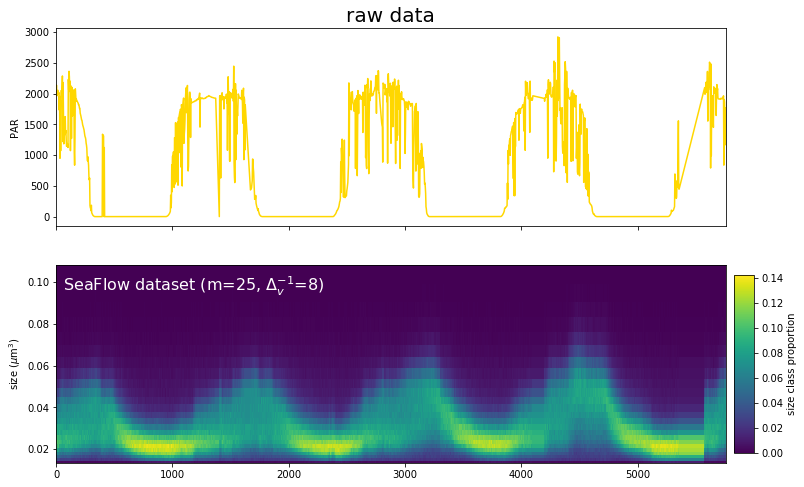

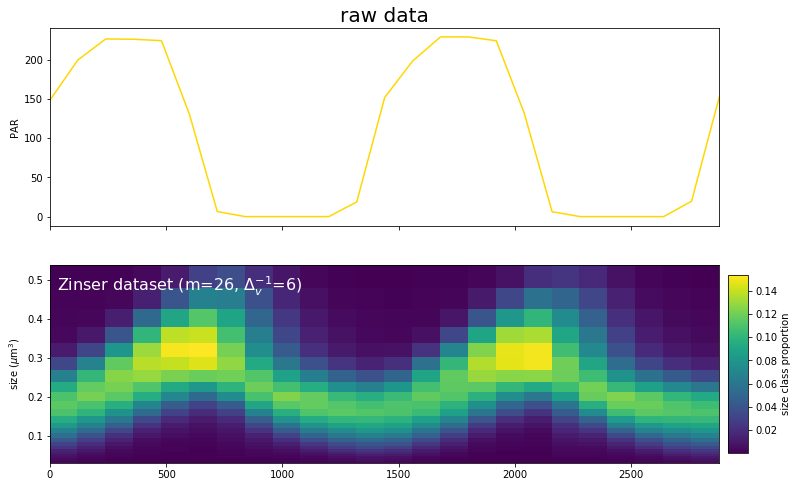

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    # remove last index, so that dimensions agree
    data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

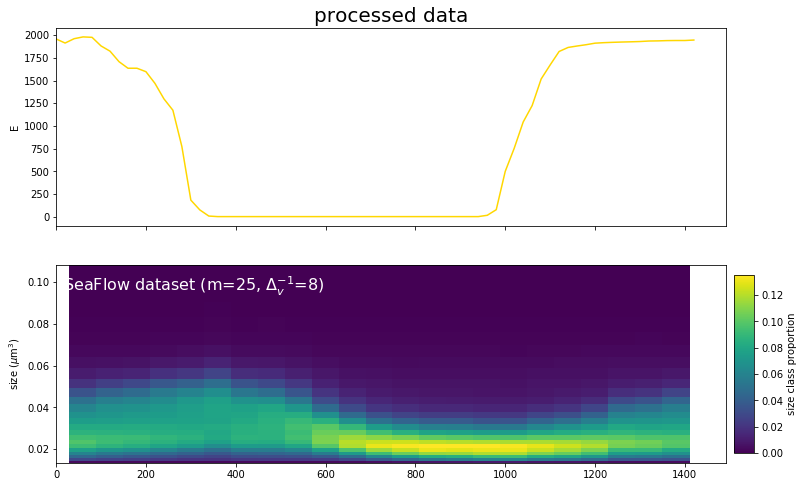

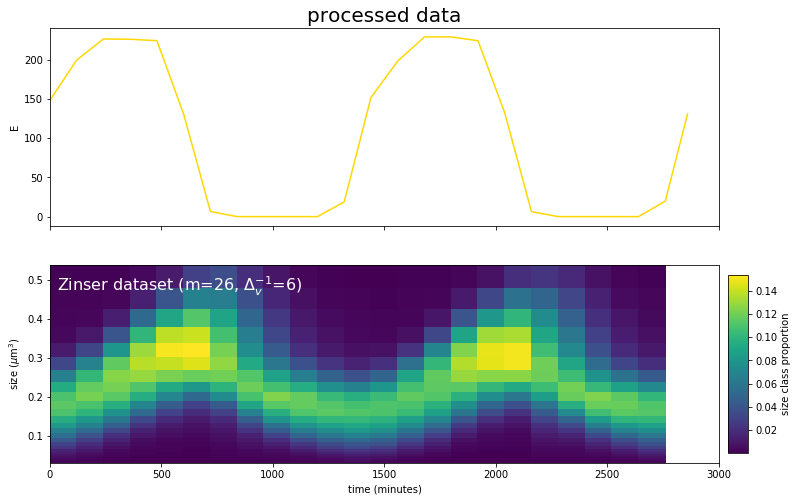

In [4]:
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [5]:
import pystan
import re

desc_model = {
    'v7_orig':'growth/respiration v7, original prior',
    'v7_m40':'growth/respiration v7, gamma_max < 40',
    'v7_m20':'growth/respiration v7, gamma_max < 20',
    'v7_m10':'growth/respiration v7, gamma_max < 10',
    'v7_n20':'growth/respiration v7, gamma_max ~ normal(20,10)',
    'v7_n10':'growth/respiration v7, gamma_max ~ normal(10,5)',
    'v7_n5':'growth/respiration v7, gamma_max ~ normal(5,2.5)',
}
# preparing for some regular expression magic
model_code_replacements = {
    'v7_orig':(),
    'v7_m40':(('^( *gamma_max *~)',' uniform(0.0, 40.0);'),('^( *real<lower=0)> gamma_max;',',upper=1440.0/dt> gamma_max;')),
    'v7_m20':(('^( *gamma_max *~)',' uniform(0.0, 20.0);'),('^( *real<lower=0)> gamma_max;',',upper=1440.0/dt> gamma_max;')),
    'v7_m10':(('^( *gamma_max *~)',' uniform(0.0, 10.0);'),('^( *real<lower=0)> gamma_max;',',upper=1440.0/dt> gamma_max;')),
    'v7_n20':(('^( *gamma_max *~)',' normal(20.0,10.0);'),('^( *real<lower=0)> gamma_max;',',upper=1440.0/dt> gamma_max;')),
    'v7_n10':(('^( *gamma_max *~)',' normal(10.0,5.0);'),('^( *real<lower=0)> gamma_max;',',upper=1440.0/dt> gamma_max;')),
    'v7_n5':(('^( *gamma_max *~)',' normal(5.0,2.5);'),('^( *real<lower=0)> gamma_max;',',upper=1440.0/dt> gamma_max;')),
}
model_stan_key = {
    'v7_orig':'monodelta_respiv7_mn',
    'v7_m40':'monodelta_respiv7_mn',
    'v7_m20':'monodelta_respiv7_mn',
    'v7_m10':'monodelta_respiv7_mn',
    'v7_n20':'monodelta_respiv7_mn',
    'v7_n10':'monodelta_respiv7_mn',
    'v7_n5':'monodelta_respiv7_mn',
}
stan_files = {
    'monodelta_respiv7_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_orig NOW.


v7_m40: patching in "    real<lower=0,upper=1440.0/dt> gamma_max;"
v7_m40: patching in "    gamma_max ~ uniform(0.0, 40.0);"
v7_m20: patching in "    real<lower=0,upper=1440.0/dt> gamma_max;"
v7_m20: patching in "    gamma_max ~ uniform(0.0, 20.0);"
v7_m10: patching in "    real<lower=0,upper=1440.0/dt> gamma_max;"
v7_m10: patching in "    gamma_max ~ uniform(0.0, 10.0);"
v7_n20: patching in "    real<lower=0,upper=1440.0/dt> gamma_max;"
v7_n20: patching in "    gamma_max ~ normal(20.0,10.0);"
v7_n10: patching in "    real<lower=0,upper=1440.0/dt> gamma_max;"
v7_n10: patching in "    gamma_max ~ normal(10.0,5.0);"
v7_n5: patching in "    real<lower=0,upper=1440.0/dt> gamma_max;"
v7_n5: patching in "    gamma_max ~ normal(5.0,2.5);"
v7_orig: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_m40 NOW.


v7_m40: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_m20 NOW.


v7_m20: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_m10 NOW.


v7_m10: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_n20 NOW.


v7_n20: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_n10 NOW.


v7_n10: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_n5 NOW.


v7_n5: compiling


In [6]:
import time
refit_all = False
refit_required = {}

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

def get_mean_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmean(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'meanrhats' not in globals():
    meanrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

    
try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    if name not in sampling_time:
        sampling_time[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if dataname not in sampling_time[name]:
            sampling_time[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            sampling_time[name][dataname].append(time.time() - t0) # in seconds
            meanrhats[name][dataname].append(get_mean_rhat(mcmcs[name][dataname]))
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

v7_orig (growth/respiration v7, original prior)
Inference for Stan model: v7_orig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.5e-3   0.09   0.17   0.24   0.29   0.36   0.52    668   1.01
gamma_max             1.3  1.6e-3   0.05    1.2   1.27    1.3   1.34    1.4   1055    1.0
xi                   0.03  3.2e-3    0.1  -0.17  -0.04   0.03    0.1   0.22   1000   1.01
xir                8.1e-4  3.3e-3    0.1   -0.2  -0.07 1.6e-3   0.07   0.21   1000    1.0
respiration          0.11  8.0e-4   0.02   0.06   0.09   0.11   0.12   0.15    689    1.0
E_star               8.66    0.83  19.41   0.09   0.81   1.75   4.42  66.47    553    1.0
divrate              0.68  1.1e-3   0.03   0.62   0.66   0.68    0.7   0.73    686   1.01
delta_max[1]         0.03  8.4e-4   0.02 1.0e-3 9.5e-3   0.02   0.04   0.09    

v7_orig: in try 1/3 found Rhat=1275.109, trying again


v7_orig (growth/respiration v7, original prior)
Inference for Stan model: v7_orig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.25  9.0e-3   0.52   1.36    1.9   2.21   2.56   3.37   3297    1.0
gamma_max            8.12    0.66   4.83   6.81   7.24   7.52   7.88   9.07     54   1.05
xi                  -1.32  1.5e-3   0.09  -1.51  -1.39  -1.33  -1.26  -1.13   4073    1.0
xir                  0.45  1.7e-3    0.1   0.26   0.39   0.46   0.52   0.64   3346    1.0
respiration          1.69  2.7e-3   0.09   1.51   1.63   1.69   1.75   1.85   1072    1.0
E_star             136.06   23.37 170.56  85.11 102.47 114.76 129.33 179.06     53   1.05
divrate              0.64  8.3e-4   0.04   0.57   0.62   0.64   0.67   0.73   2458    1.0
delta_max[1]         0.05  1.2e-3   0.03 3.6e-3   0.02   0.05   0.07    0.1    

v7_m40 (growth/respiration v7, gamma_max < 40)
Inference for Stan model: v7_m40.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.9e-3   0.09   0.18   0.25    0.3   0.36   0.53    549    1.0
gamma_max             1.3  1.8e-3   0.05    1.2   1.27    1.3   1.34   1.41    898    1.0
xi                   0.03  3.4e-3    0.1  -0.17  -0.04   0.03    0.1   0.23    902    1.0
xir                6.6e-3  3.4e-3    0.1  -0.19  -0.06 5.2e-3   0.07   0.21    886    1.0
respiration          0.11  8.9e-4   0.02   0.07    0.1   0.11   0.13   0.15    577   1.01
E_star               9.19     0.9  21.94   0.06   0.88   1.69    4.1  69.72    598    1.0
divrate              0.67  1.1e-3   0.03   0.62   0.66   0.67   0.69   0.73    625   1.01
delta_max[1]         0.02  1.1e-3   0.02 6.9e-4 6.9e-3   0.02   0.03   0.08    45

v7_m40: in try 1/3 found Rhat=7475.893, trying again


v7_m40: in try 2/3 found Rhat=373.022, trying again


v7_m40: in try 3/3 found Rhat=384.071, trying again
v7_m40 (growth/respiration v7, gamma_max < 40)
Inference for Stan model: v7_m40.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.39    0.54    0.8   0.45   0.64    0.9   2.01   2.91      2   3.29
gamma_max           31.89    9.93  14.05   6.99  24.74   40.0   40.0   40.0      2  56.04
xi                  -0.33     0.4   0.57  -1.44  -0.58-2.1e-4-3.0e-5 1.9e-4      2  14.18
xir                  1.23     2.6   3.68  -3.93  -2.11   1.37   4.41   6.36      2  87.05
respiration          0.66    0.43    0.6    0.2   0.25   0.37   0.99   1.79      2   16.2
E_star             2293.2  1184.1 1675.3  92.85 659.54 2538.6 3938.3 4072.9      2  97.46
divrate              1.71    0.71   1.01   0.59   0.99   1.42   2.47   3.47      2  34.62
delta_max[1]         0.57    

v7_m20: in try 1/3 found Rhat=10.156, trying again


v7_m20 (growth/respiration v7, gamma_max < 20)
Inference for Stan model: v7_m20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.32  3.6e-3   0.09   0.17   0.25    0.3   0.37   0.54    674    1.0
gamma_max             1.3  2.2e-3   0.06   1.19   1.26    1.3   1.34   1.41    647   1.01
xi                   0.03  3.3e-3    0.1  -0.16  -0.04   0.03    0.1   0.22    939    1.0
xir               -5.1e-3  2.9e-3    0.1   -0.2  -0.07-5.3e-3   0.06    0.2   1213    1.0
respiration          0.11  9.1e-4   0.02   0.06    0.1   0.11   0.12   0.15    550   1.01
E_star              10.82    1.72  31.02   0.06   0.85   1.77   4.77  77.23    327   1.01
divrate              0.68  1.1e-3   0.03   0.62   0.66   0.68    0.7   0.73    620   1.01
delta_max[1]         0.03  8.4e-4   0.02 7.2e-4 8.8e-3   0.02   0.04   0.08    71

v7_m20: in try 1/3 found Rhat=4138.706, trying again


v7_m20: in try 2/3 found Rhat=5331.130, trying again


v7_m20: in try 3/3 found Rhat=5521.223, trying again
v7_m20 (growth/respiration v7, gamma_max < 20)
Inference for Stan model: v7_m20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         4.33    0.72   1.02   3.05   3.45   4.19   5.23   5.87      2 892.05
gamma_max            20.0  2.4e-5 4.1e-4   20.0   20.0   20.0   20.0   20.0    281   1.02
xi                   0.54    1.95   2.76  -2.61  -1.57  -0.15   2.83   5.04      2 106.29
xir                  2.33    4.07   5.75  -7.05  -2.86   4.64   7.04    7.1      2 3086.9
respiration          1.55     0.7   0.99   0.49    0.7    1.3   2.45   3.12      2 1557.2
E_star             1587.6  776.78 1098.8 418.33 772.31 1269.0 2467.3 3393.3      2 975.46
divrate              1.25    0.23   0.33    1.0   1.01   1.06   1.54   1.81      2  27.85
delta_max[1]         1.65   

v7_m10: in try 1/3 found Rhat=26.948, trying again


v7_m10: in try 2/3 found Rhat=12.983, trying again


v7_m10: in try 3/3 found Rhat=132.193, trying again
v7_m10 (growth/respiration v7, gamma_max < 10)
Inference for Stan model: v7_m10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.62    0.41   0.58    0.2   0.24    0.3   1.24   1.63      2    9.9
gamma_max            5.65    3.07   4.35   1.22    1.3   5.74   10.0   10.0      2 117.66
xi                   2.74    1.99   2.81  -0.15   0.03   2.33    5.5   6.62      2  36.83
xir                 -0.89    2.33   3.29  -6.29  -3.56 3.3e-4   1.51   2.76      2  47.28
respiration          0.23    0.09   0.22   0.06    0.1   0.12   0.25   0.97      6   1.88
E_star             1991.7  1403.7 1985.7   0.19   1.77 1983.2 4000.0 4167.2      2 132.19
divrate              1.29    0.44   0.63   0.62   0.68   1.09   1.84   2.12      2  12.15
delta_max[1]         1.01    

v7_m10: in try 1/3 found Rhat=6062.838, trying again


v7_m10: in try 2/3 found Rhat=2406.245, trying again


v7_m10: in try 3/3 found Rhat=6567.013, trying again
v7_m10 (growth/respiration v7, gamma_max < 10)
Inference for Stan model: v7_m10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.42    0.62   0.88    1.3   1.55   2.49   3.28   3.42      2 896.07
gamma_max            10.0  1.5e-4 4.9e-4   10.0   10.0   10.0   10.0   10.0     11   1.21
xi                  -2.64    3.62   5.12  -6.97  -6.47  -4.78   1.57   6.06      2  352.4
xir                 -2.13    1.85   2.61  -4.98  -4.78  -2.25   0.49   1.07      2 162.68
respiration          0.55    0.24   0.37   0.13   0.22   0.36   1.03   1.05      2   6.61
E_star             2746.0  871.27 1232.4 729.32 1681.4 3130.3 3735.0 3990.7      2 1913.0
divrate              0.75    0.26   0.36   0.18   0.45   0.83   1.05   1.18      2 369.96
delta_max[1]         1.44   

v7_n20 (growth/respiration v7, gamma_max ~ normal(20,10))
Inference for Stan model: v7_n20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.4e-3   0.09   0.18   0.25    0.3   0.36   0.52    654    1.0
gamma_max             1.3  1.8e-3   0.05    1.2   1.26    1.3   1.34   1.41    920    1.0
xi                   0.03  3.0e-3    0.1  -0.16  -0.04   0.03    0.1   0.23   1104    1.0
xir               -2.1e-3  4.1e-3    0.1   -0.2  -0.07-3.7e-5   0.07   0.19    606   1.01
respiration          0.11  1.1e-3   0.02   0.06    0.1   0.11   0.12   0.15    381   1.01
E_star                8.6    0.97  23.54   0.08   0.78   1.63   3.75  68.19    587   1.02
divrate              0.68 10.0e-4   0.03   0.62   0.66   0.68    0.7   0.73    762    1.0
delta_max[1]         0.03  1.1e-3   0.02 7.1e-4 8.4e-3   0.02   0.04  

v7_n20: in try 1/3 found Rhat=2623.024, trying again


v7_n20: in try 2/3 found Rhat=805.313, trying again


v7_n20: in try 3/3 found Rhat=2078.822, trying again
v7_n20 (growth/respiration v7, gamma_max ~ normal(20,10))
Inference for Stan model: v7_n20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.15    0.73   1.03   0.21   0.32   0.77   2.05   2.83      2 2078.8
gamma_max           48.22    3.75    5.3  42.98  44.24   46.4  52.56  57.05      2 576.06
xi                  -1.17    1.66   2.34  -5.22  -2.86 4.7e-3   0.29   0.54      2 887.26
xir                  3.92    0.92    1.3   2.55   2.96   3.53   4.95   6.07      2 882.93
respiration          0.31    0.13   0.18   0.17   0.17   0.23   0.46   0.62      2  847.1
E_star             800.51   92.48 130.82 677.08 695.33 753.82  915.5 1016.3      2 354.03
divrate              3.99    0.27   0.38   3.46   3.65   3.99   4.33   4.51      2 297.32
delta_max[1]     

v7_n10 (growth/respiration v7, gamma_max ~ normal(10,5))
Inference for Stan model: v7_n10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.3e-3   0.09   0.17   0.24    0.3   0.36   0.53    797    1.0
gamma_max             1.3  1.8e-3   0.06    1.2   1.27    1.3   1.34   1.41    990    1.0
xi                   0.03  3.5e-3    0.1  -0.16  -0.04   0.03    0.1   0.22    800    1.0
xir               -7.6e-4  3.2e-3    0.1   -0.2  -0.07-9.9e-5   0.07   0.18    976   1.01
respiration          0.11  7.5e-4   0.02   0.07    0.1   0.11   0.12   0.15    803    1.0
E_star               8.87    0.78  24.03   0.06   0.79   1.62   3.78  69.72    949    1.0
divrate              0.68  9.6e-4   0.03   0.62   0.66   0.68    0.7   0.73    836    1.0
delta_max[1]         0.03  8.9e-4   0.02 1.1e-3 8.4e-3   0.02   0.04   

v7_n10: in try 1/3 found Rhat=1980.488, trying again
v7_n10 (growth/respiration v7, gamma_max ~ normal(10,5))
Inference for Stan model: v7_n10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.24  7.0e-3   0.53   1.35   1.87    2.2   2.56   3.42   5681    1.0
gamma_max             7.6    0.01   0.52   6.81   7.23   7.52   7.87   8.86   2107    1.0
xi                  -1.32  1.3e-3   0.09  -1.51  -1.38  -1.32  -1.26  -1.14   5433    1.0
xir                  0.45  1.5e-3    0.1   0.26   0.39   0.45   0.52   0.64   4221    1.0
respiration          1.69  1.4e-3   0.09   1.52   1.63   1.68   1.74   1.86   3520    1.0
E_star             117.74    0.46  21.48  84.94 102.51 114.75 129.66 169.06   2200    1.0
divrate              0.65  7.0e-4   0.04   0.56   0.62   0.64   0.67   0.73   3655    1.0
delta_max[1]      

v7_n5 (growth/respiration v7, gamma_max ~ normal(5,2.5))
Inference for Stan model: v7_n5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.32  3.5e-3   0.09   0.17   0.25    0.3   0.37   0.52    704   1.01
gamma_max            1.31  1.6e-3   0.05   1.19   1.27   1.31   1.34   1.41   1108    1.0
xi                   0.03  3.7e-3    0.1  -0.17  -0.04   0.03    0.1   0.24    769   1.01
xir                2.4e-3  2.9e-3    0.1  -0.21  -0.06 4.1e-3   0.07    0.2   1192    1.0
respiration          0.11  8.3e-4   0.02   0.06   0.09   0.11   0.12   0.15    674    1.0
E_star               8.58    0.74   20.9   0.11   0.91   1.73   3.86  65.79    801    1.0
divrate              0.68  9.3e-4   0.03   0.62   0.66   0.68    0.7   0.74    915    1.0
delta_max[1]         0.03  8.8e-4   0.02 7.8e-4 8.1e-3   0.02   0.04   0

v7_n5: in try 1/3 found Rhat=392.902, trying again


v7_n5: in try 2/3 found Rhat=298.110, trying again


v7_n5: in try 3/3 found Rhat=219.810, trying again
v7_n5 (growth/respiration v7, gamma_max ~ normal(5,2.5))
Inference for Stan model: v7_n5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.53    1.87   2.66   0.23    0.5   0.75   5.93   6.95      2  10.85
gamma_max           21.64    5.33  12.77   6.93   8.27  23.92  30.36  59.95      6   2.17
xi                   -1.9    1.17   1.68   -4.7  -3.72  -1.37  -0.35   0.01      2   6.49
xir                 -0.12    3.31    4.9  -7.73  -6.65   0.48   4.01   6.51      2   3.89
respiration          1.26    0.18   0.37   0.38   0.94   1.14   1.61    1.8      4   2.07
E_star              382.5  107.22 269.31   90.4 147.47 368.21 471.65 1105.8      6   2.63
divrate              2.27    1.03   1.57   0.59   0.67   2.77   4.18   4.42      2   3.38
delta_max[1]         

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

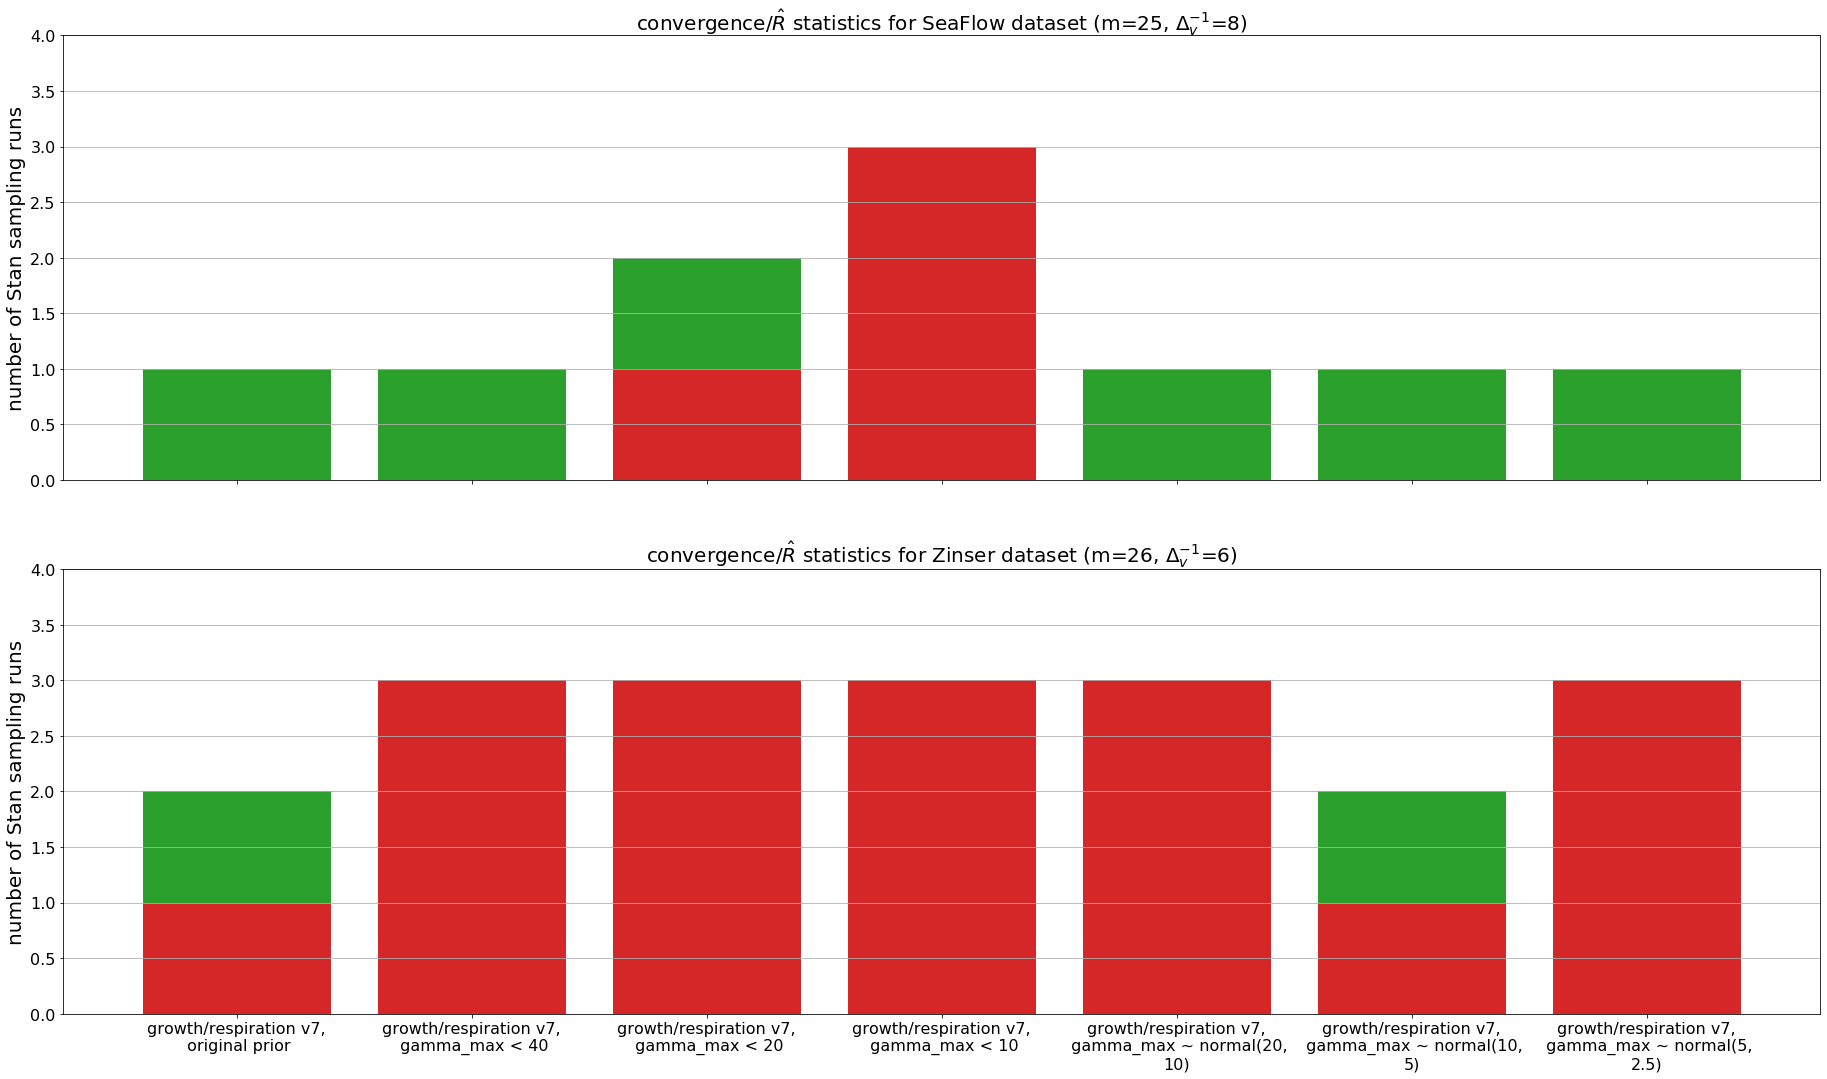

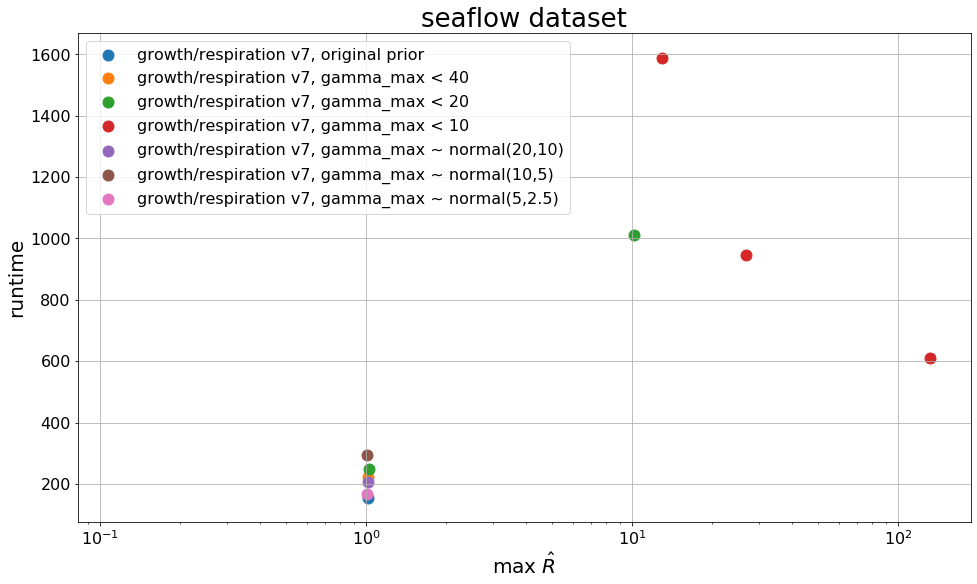

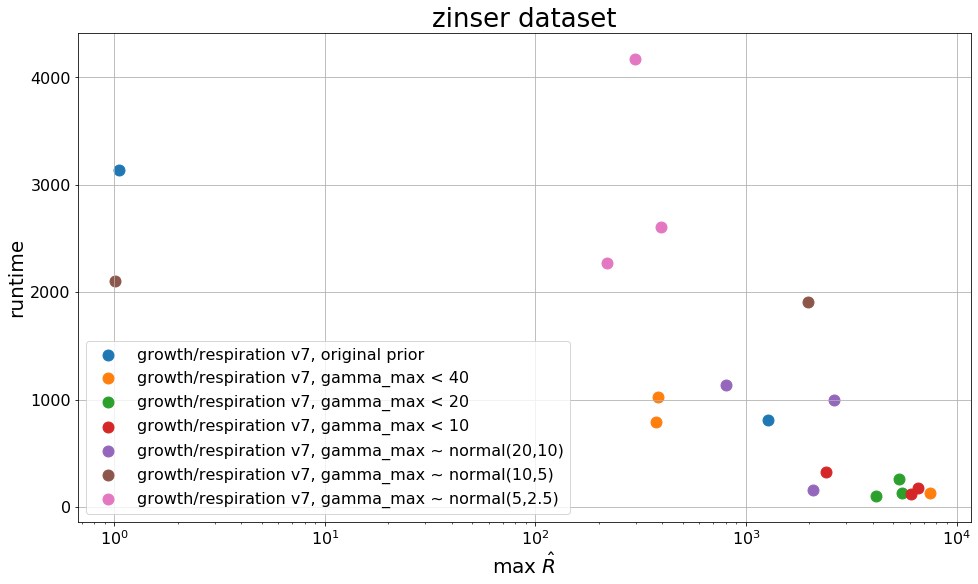

In [17]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

for dataname in data:
    fig, ax = plt.subplots(figsize=(16,9))
    ax.set_title('{} dataset'.format(dataname))
    for name in mcmcs:
        ax.scatter(maxrhats[name][dataname], sampling_time[name][dataname], label='{}'.format(desc_model[name]), s=120)

    ax.set(xlabel='max $\\hat{R}$', ylabel='runtime')
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()

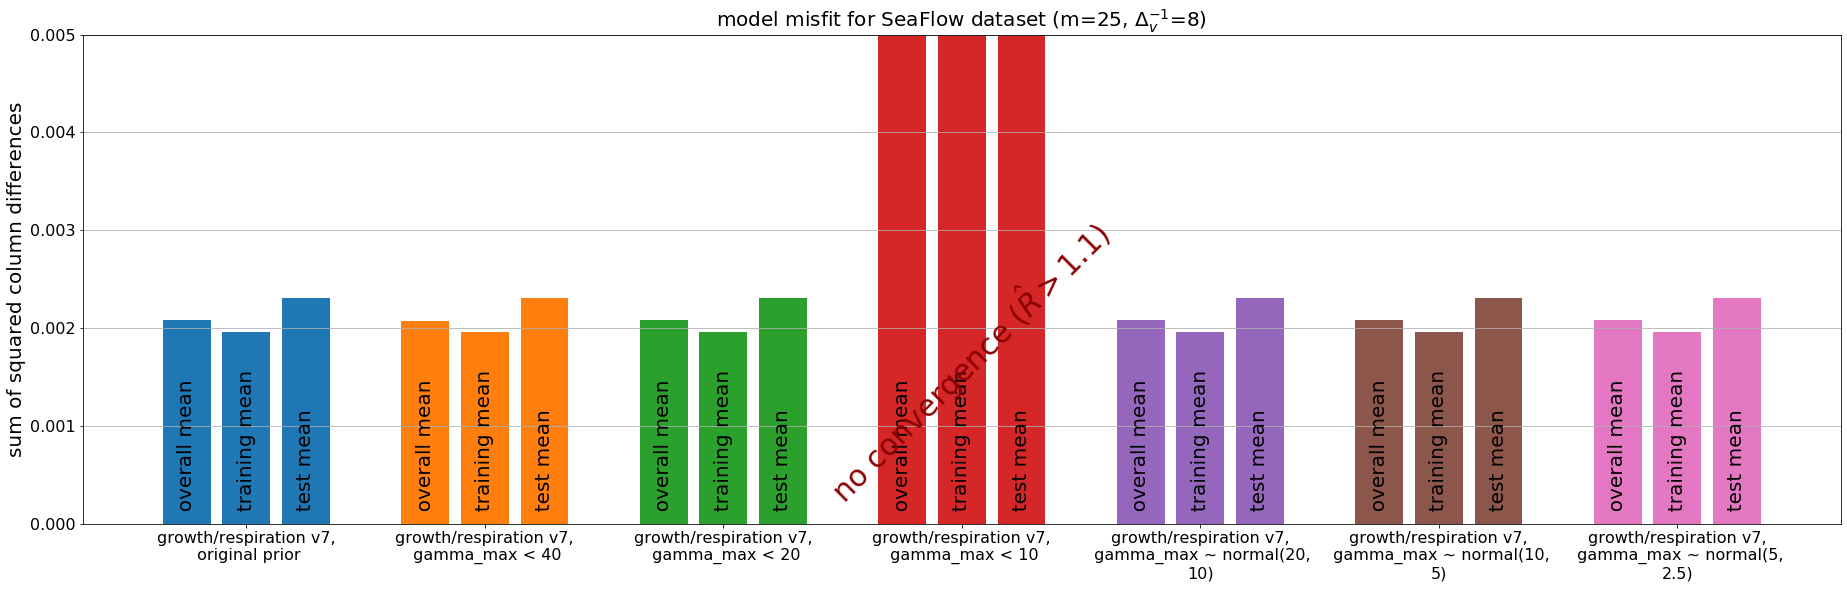

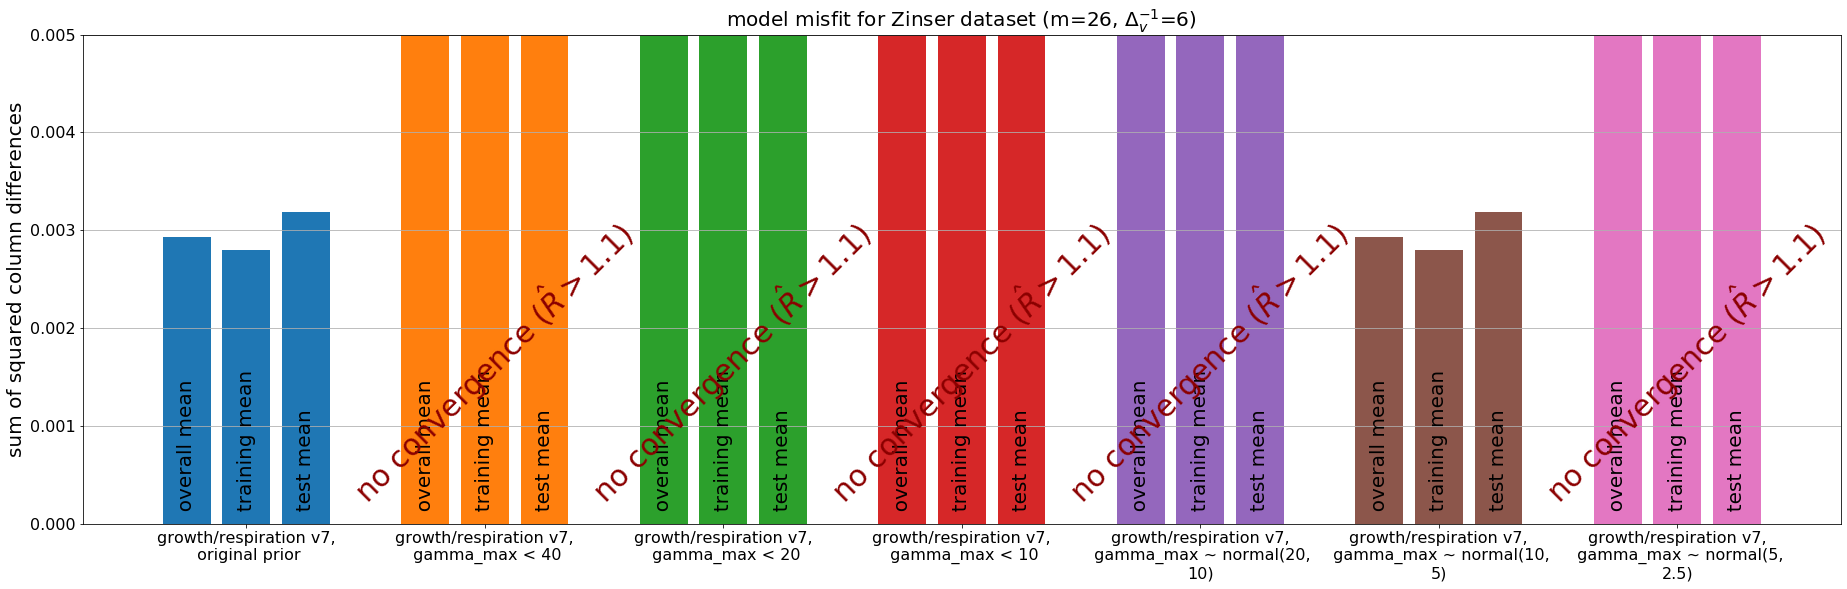

In [11]:
height = np.zeros(3)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[dataname]['i_test'] == 0])
        height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

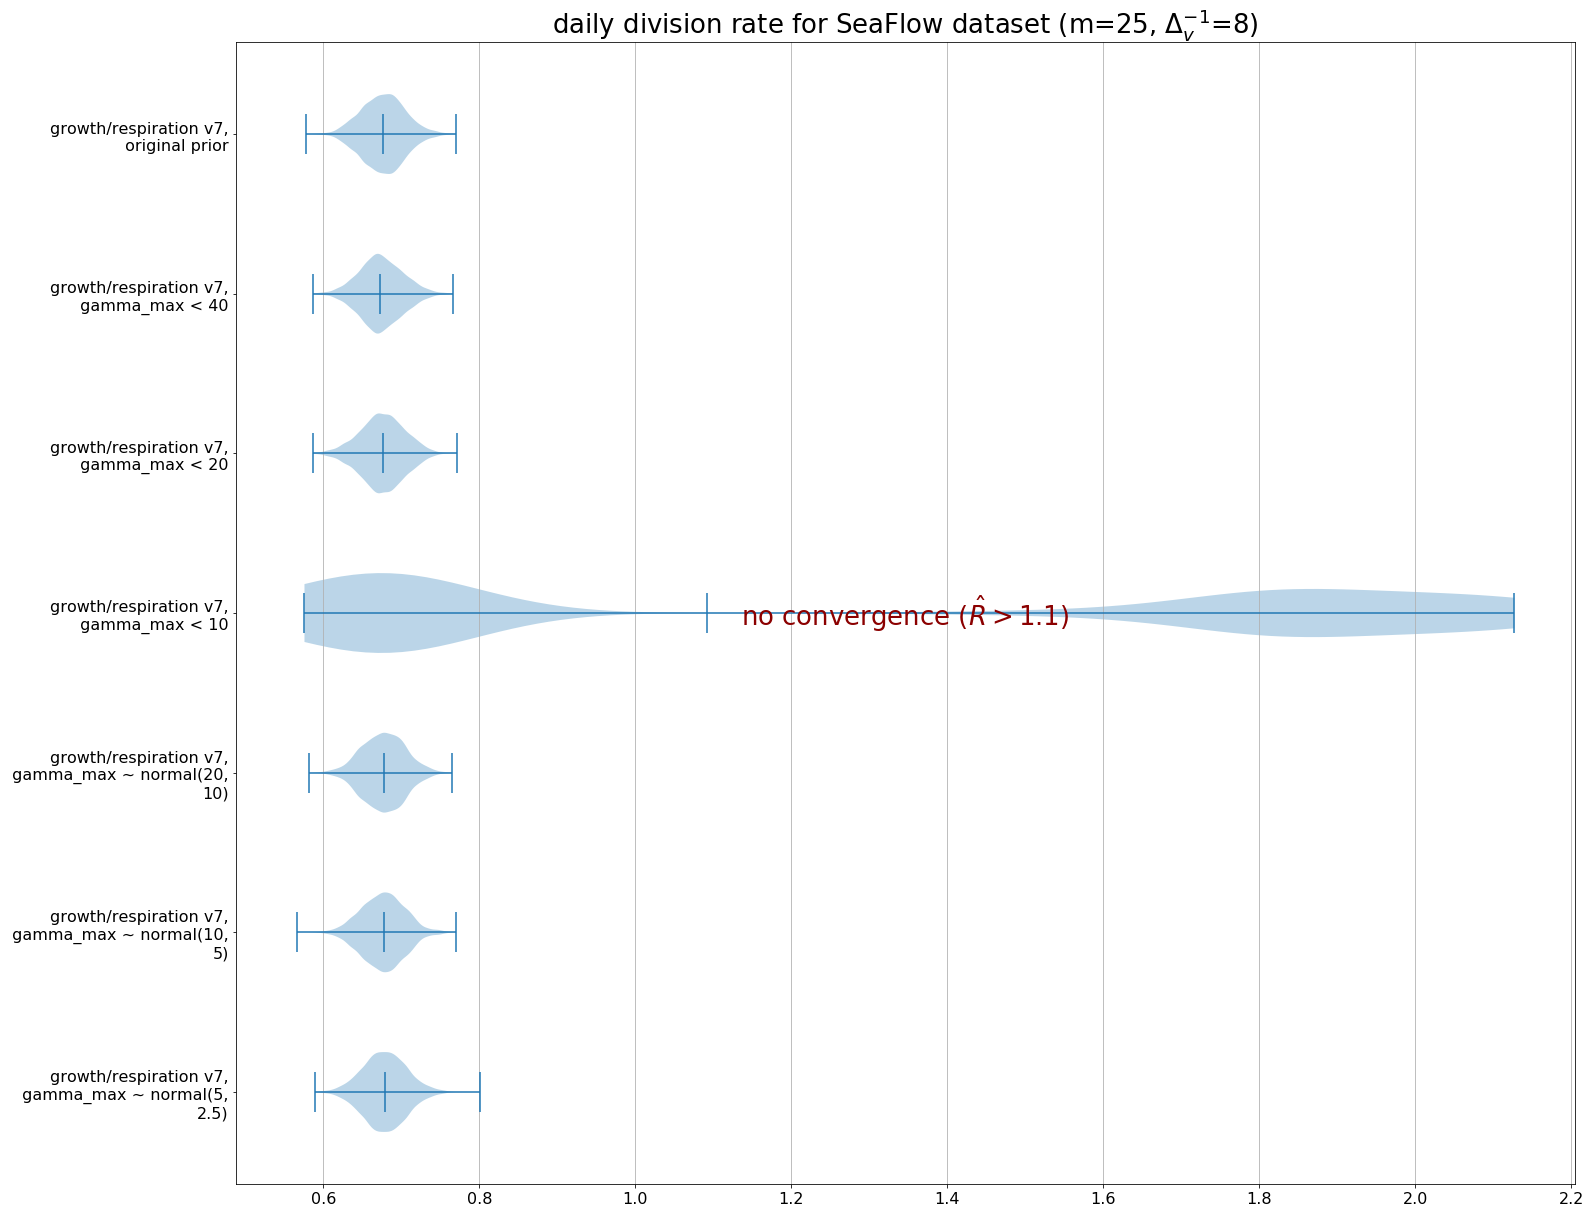

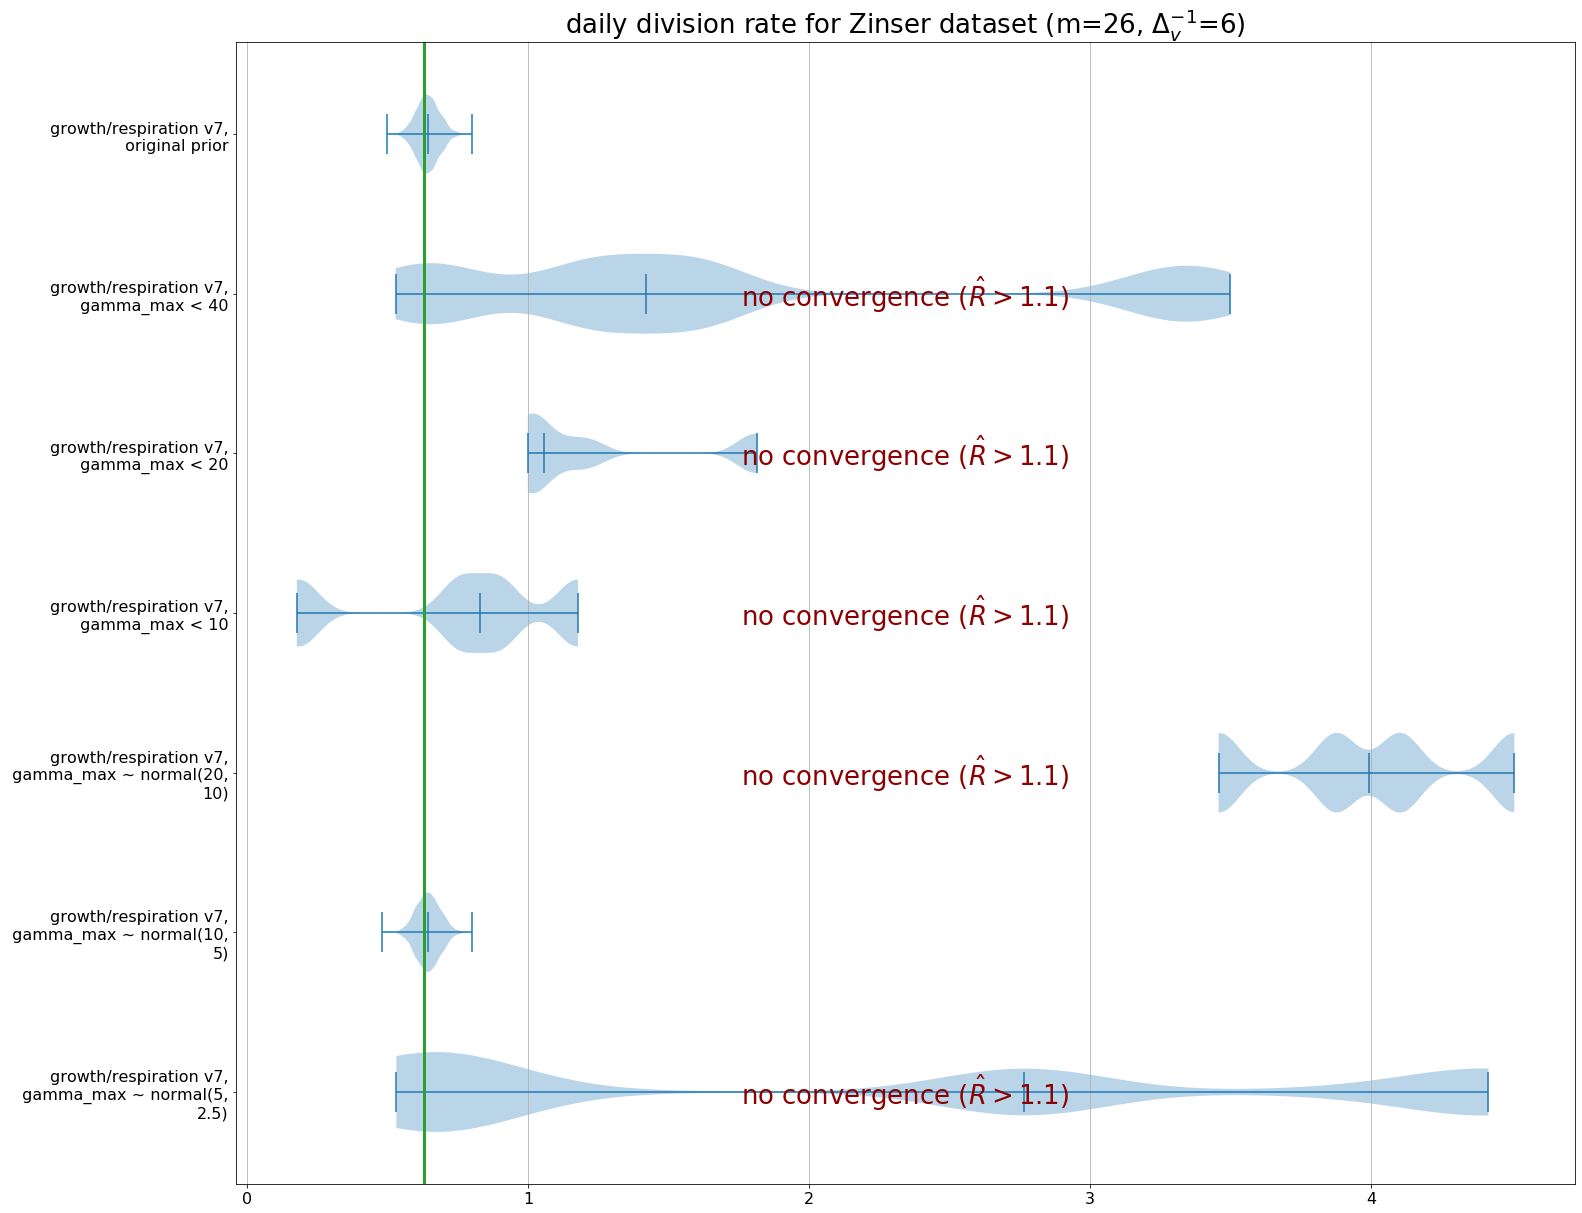

In [12]:
for dataname in data:
    num_mcmcs = len(mcmcs)
    fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
    ax.set_title('daily division rate for '+desc[dataname])
    ax.violinplot([mcmcs[name][dataname]['divrate'] for name in mcmcs], showmedians=True, vert=False)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
    if 'zinser' in dataname:
        ax.axvline(0.63, color='tab:green', lw=3)
    for i,name in enumerate(mcmcs):
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

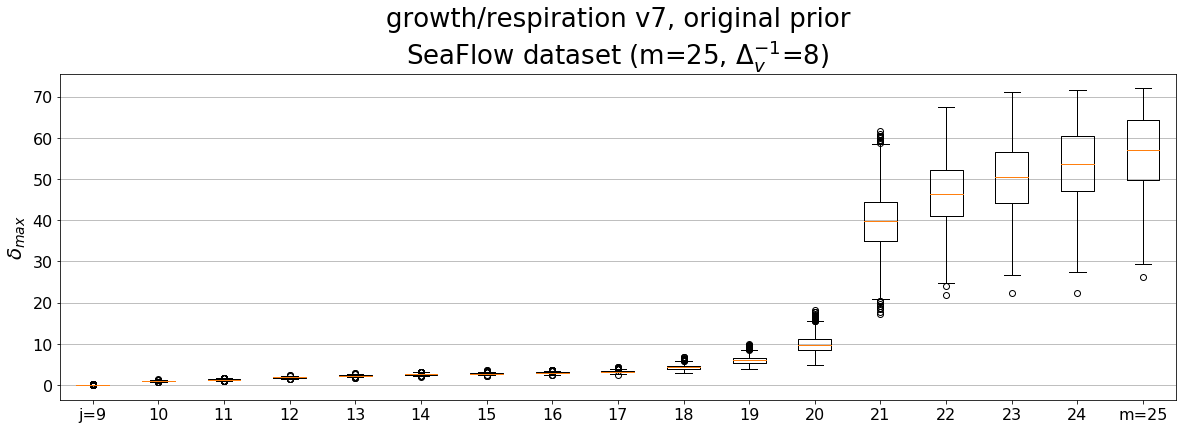

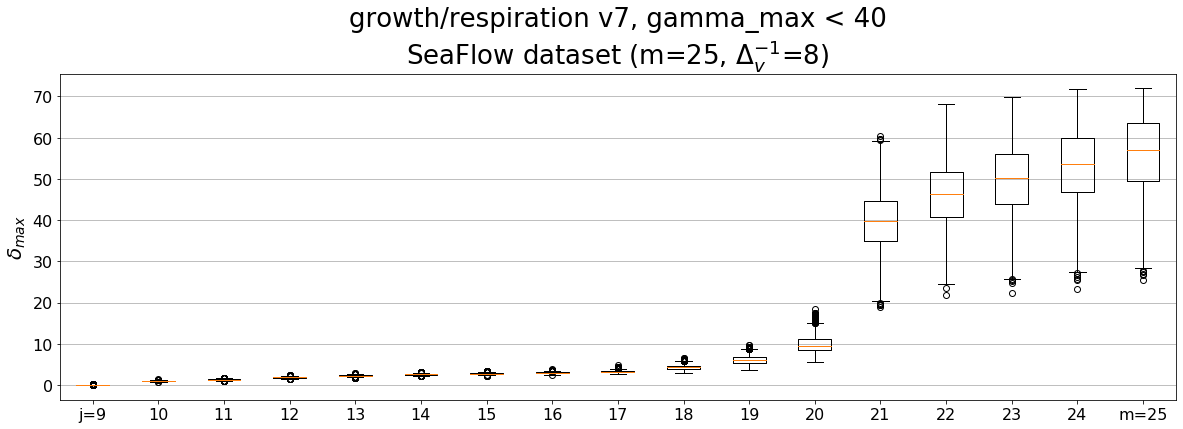

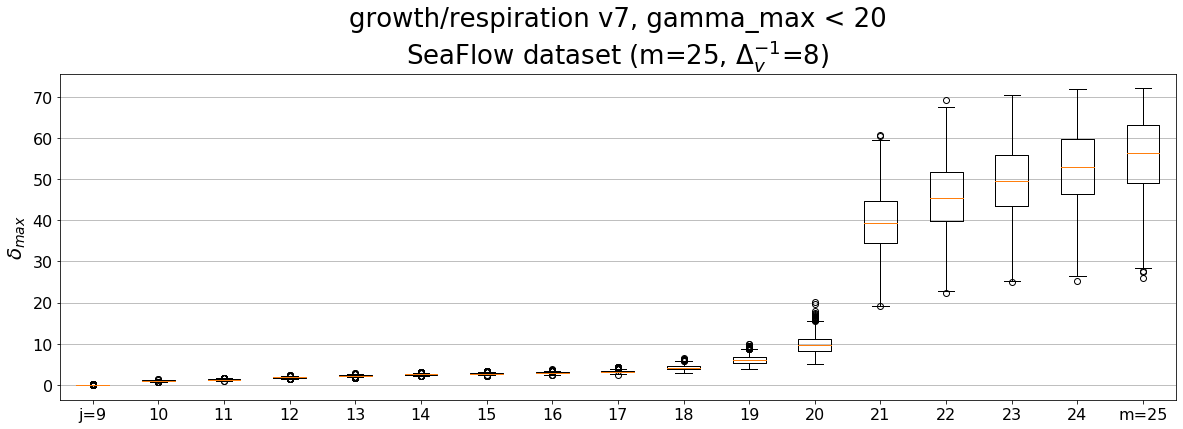

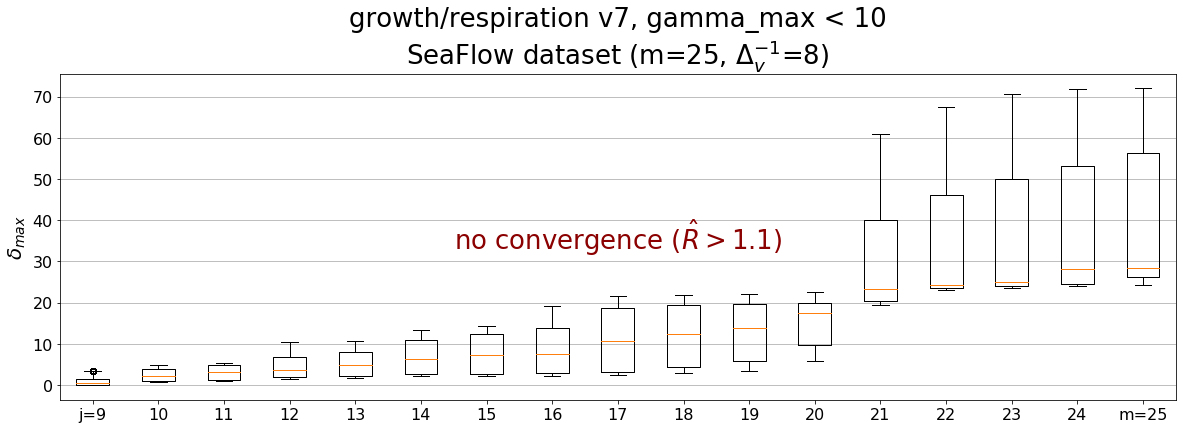

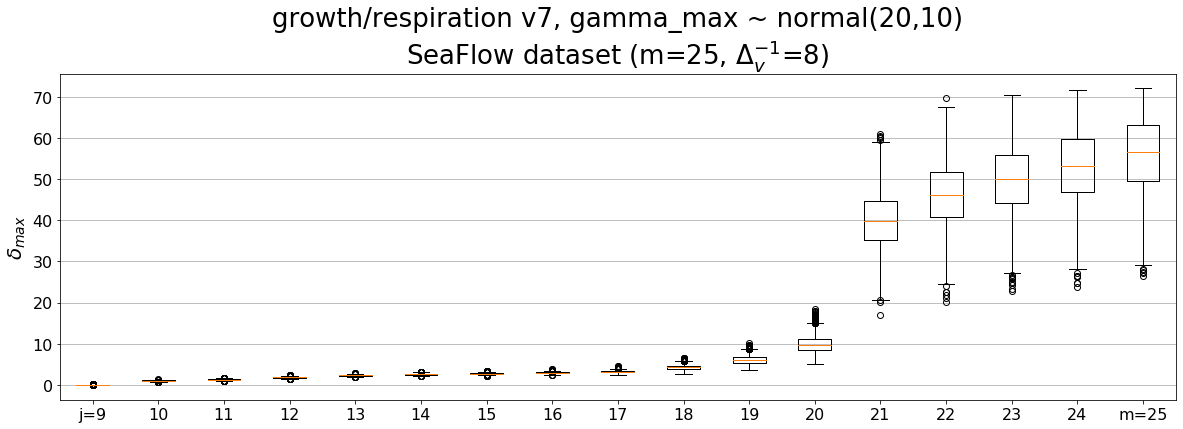

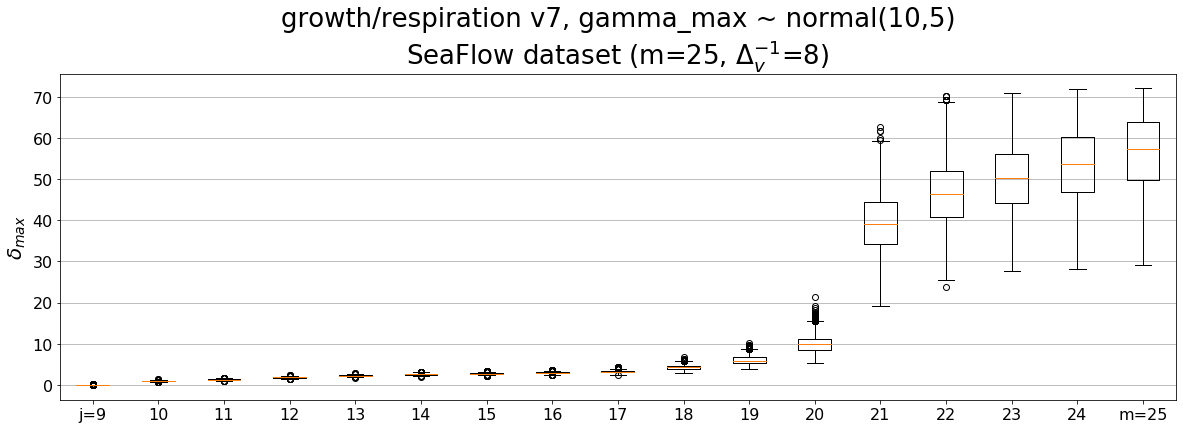

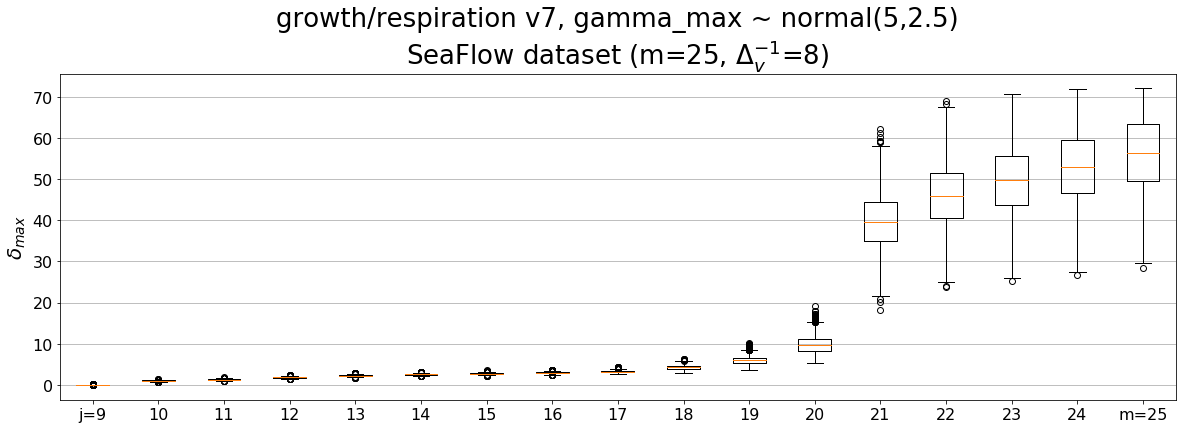

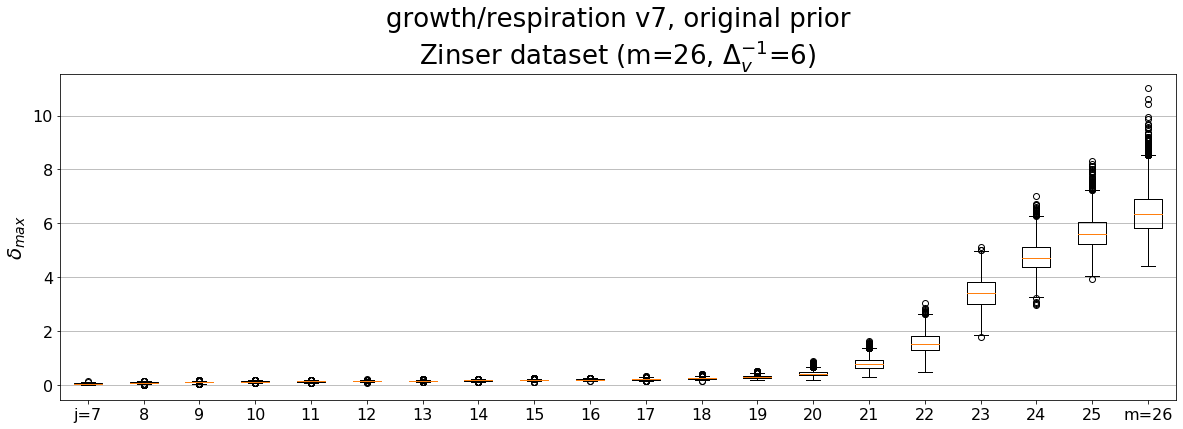

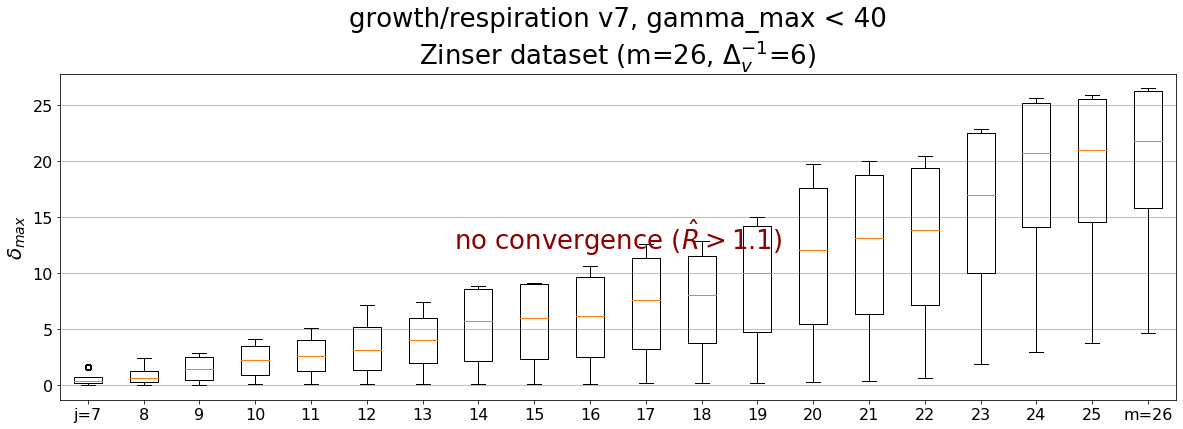

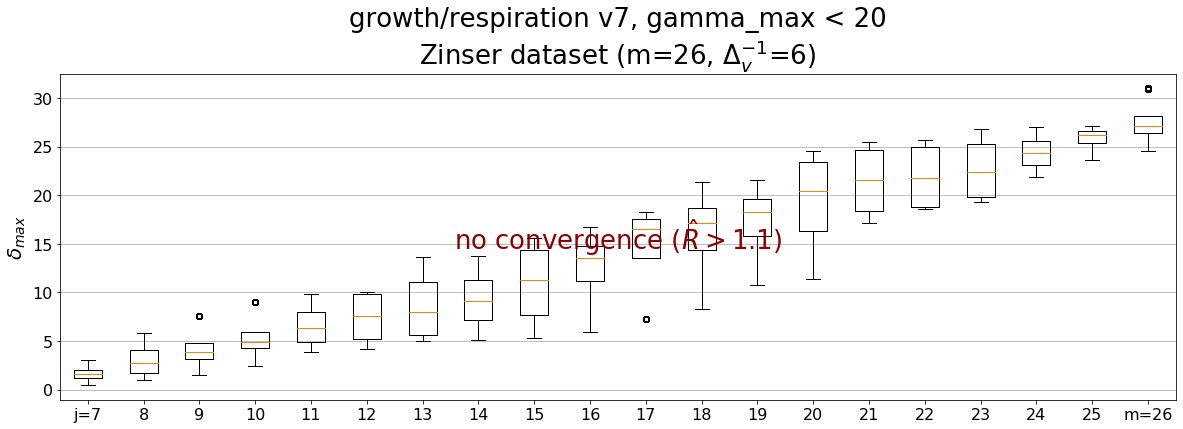

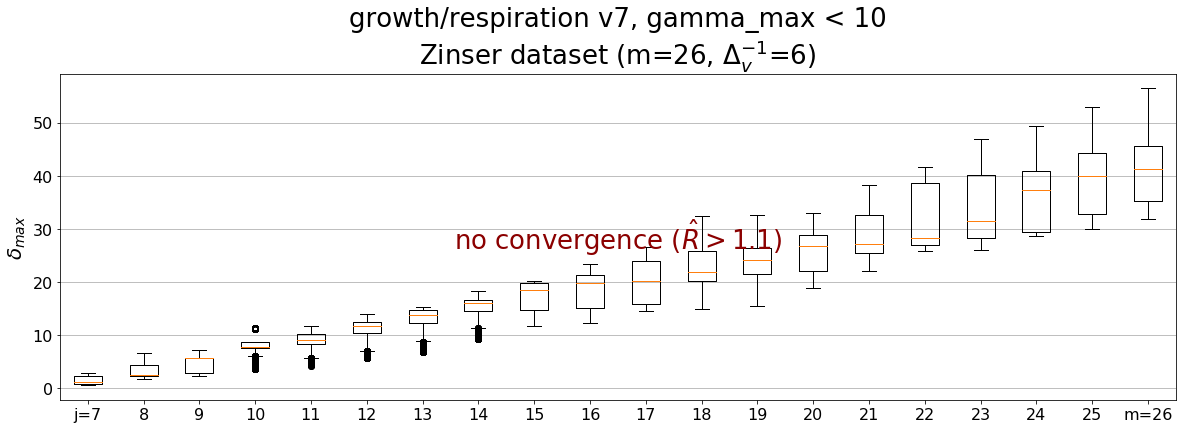

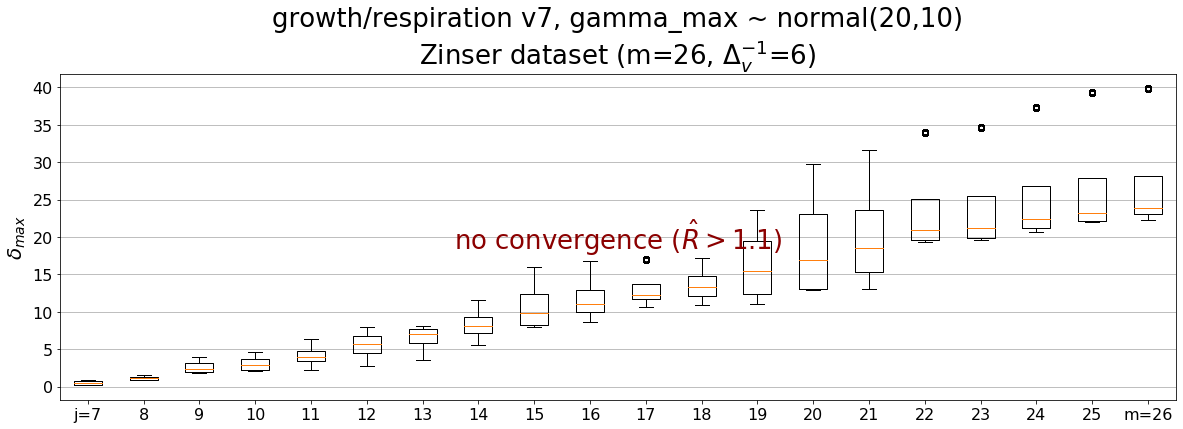

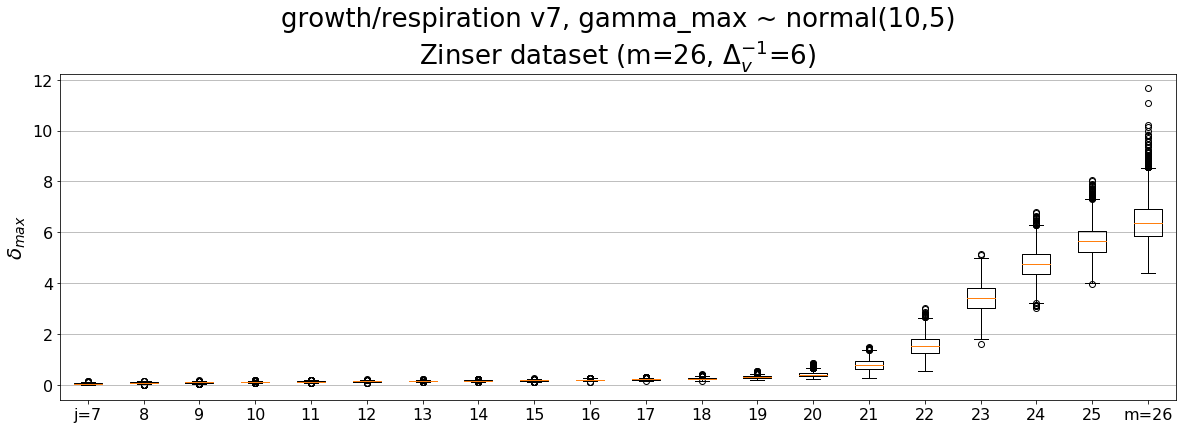

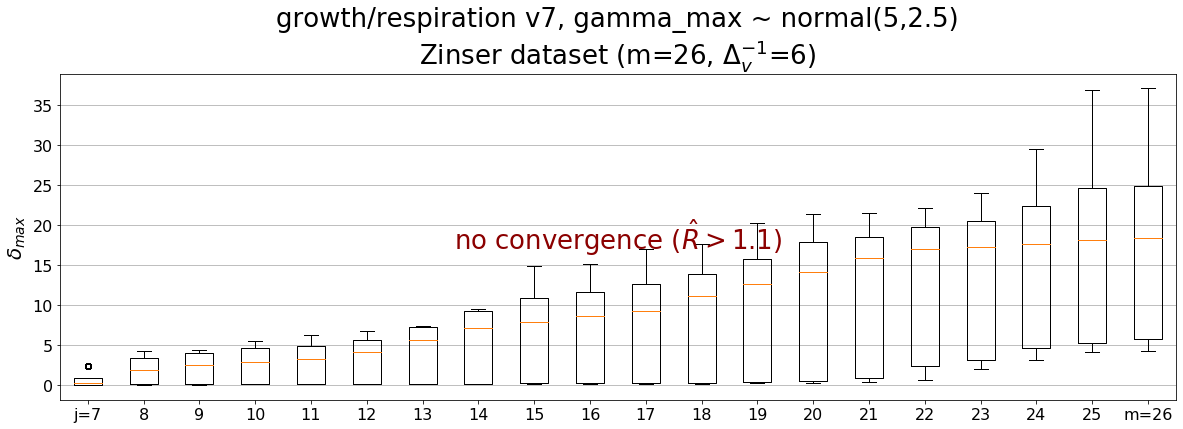

In [13]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

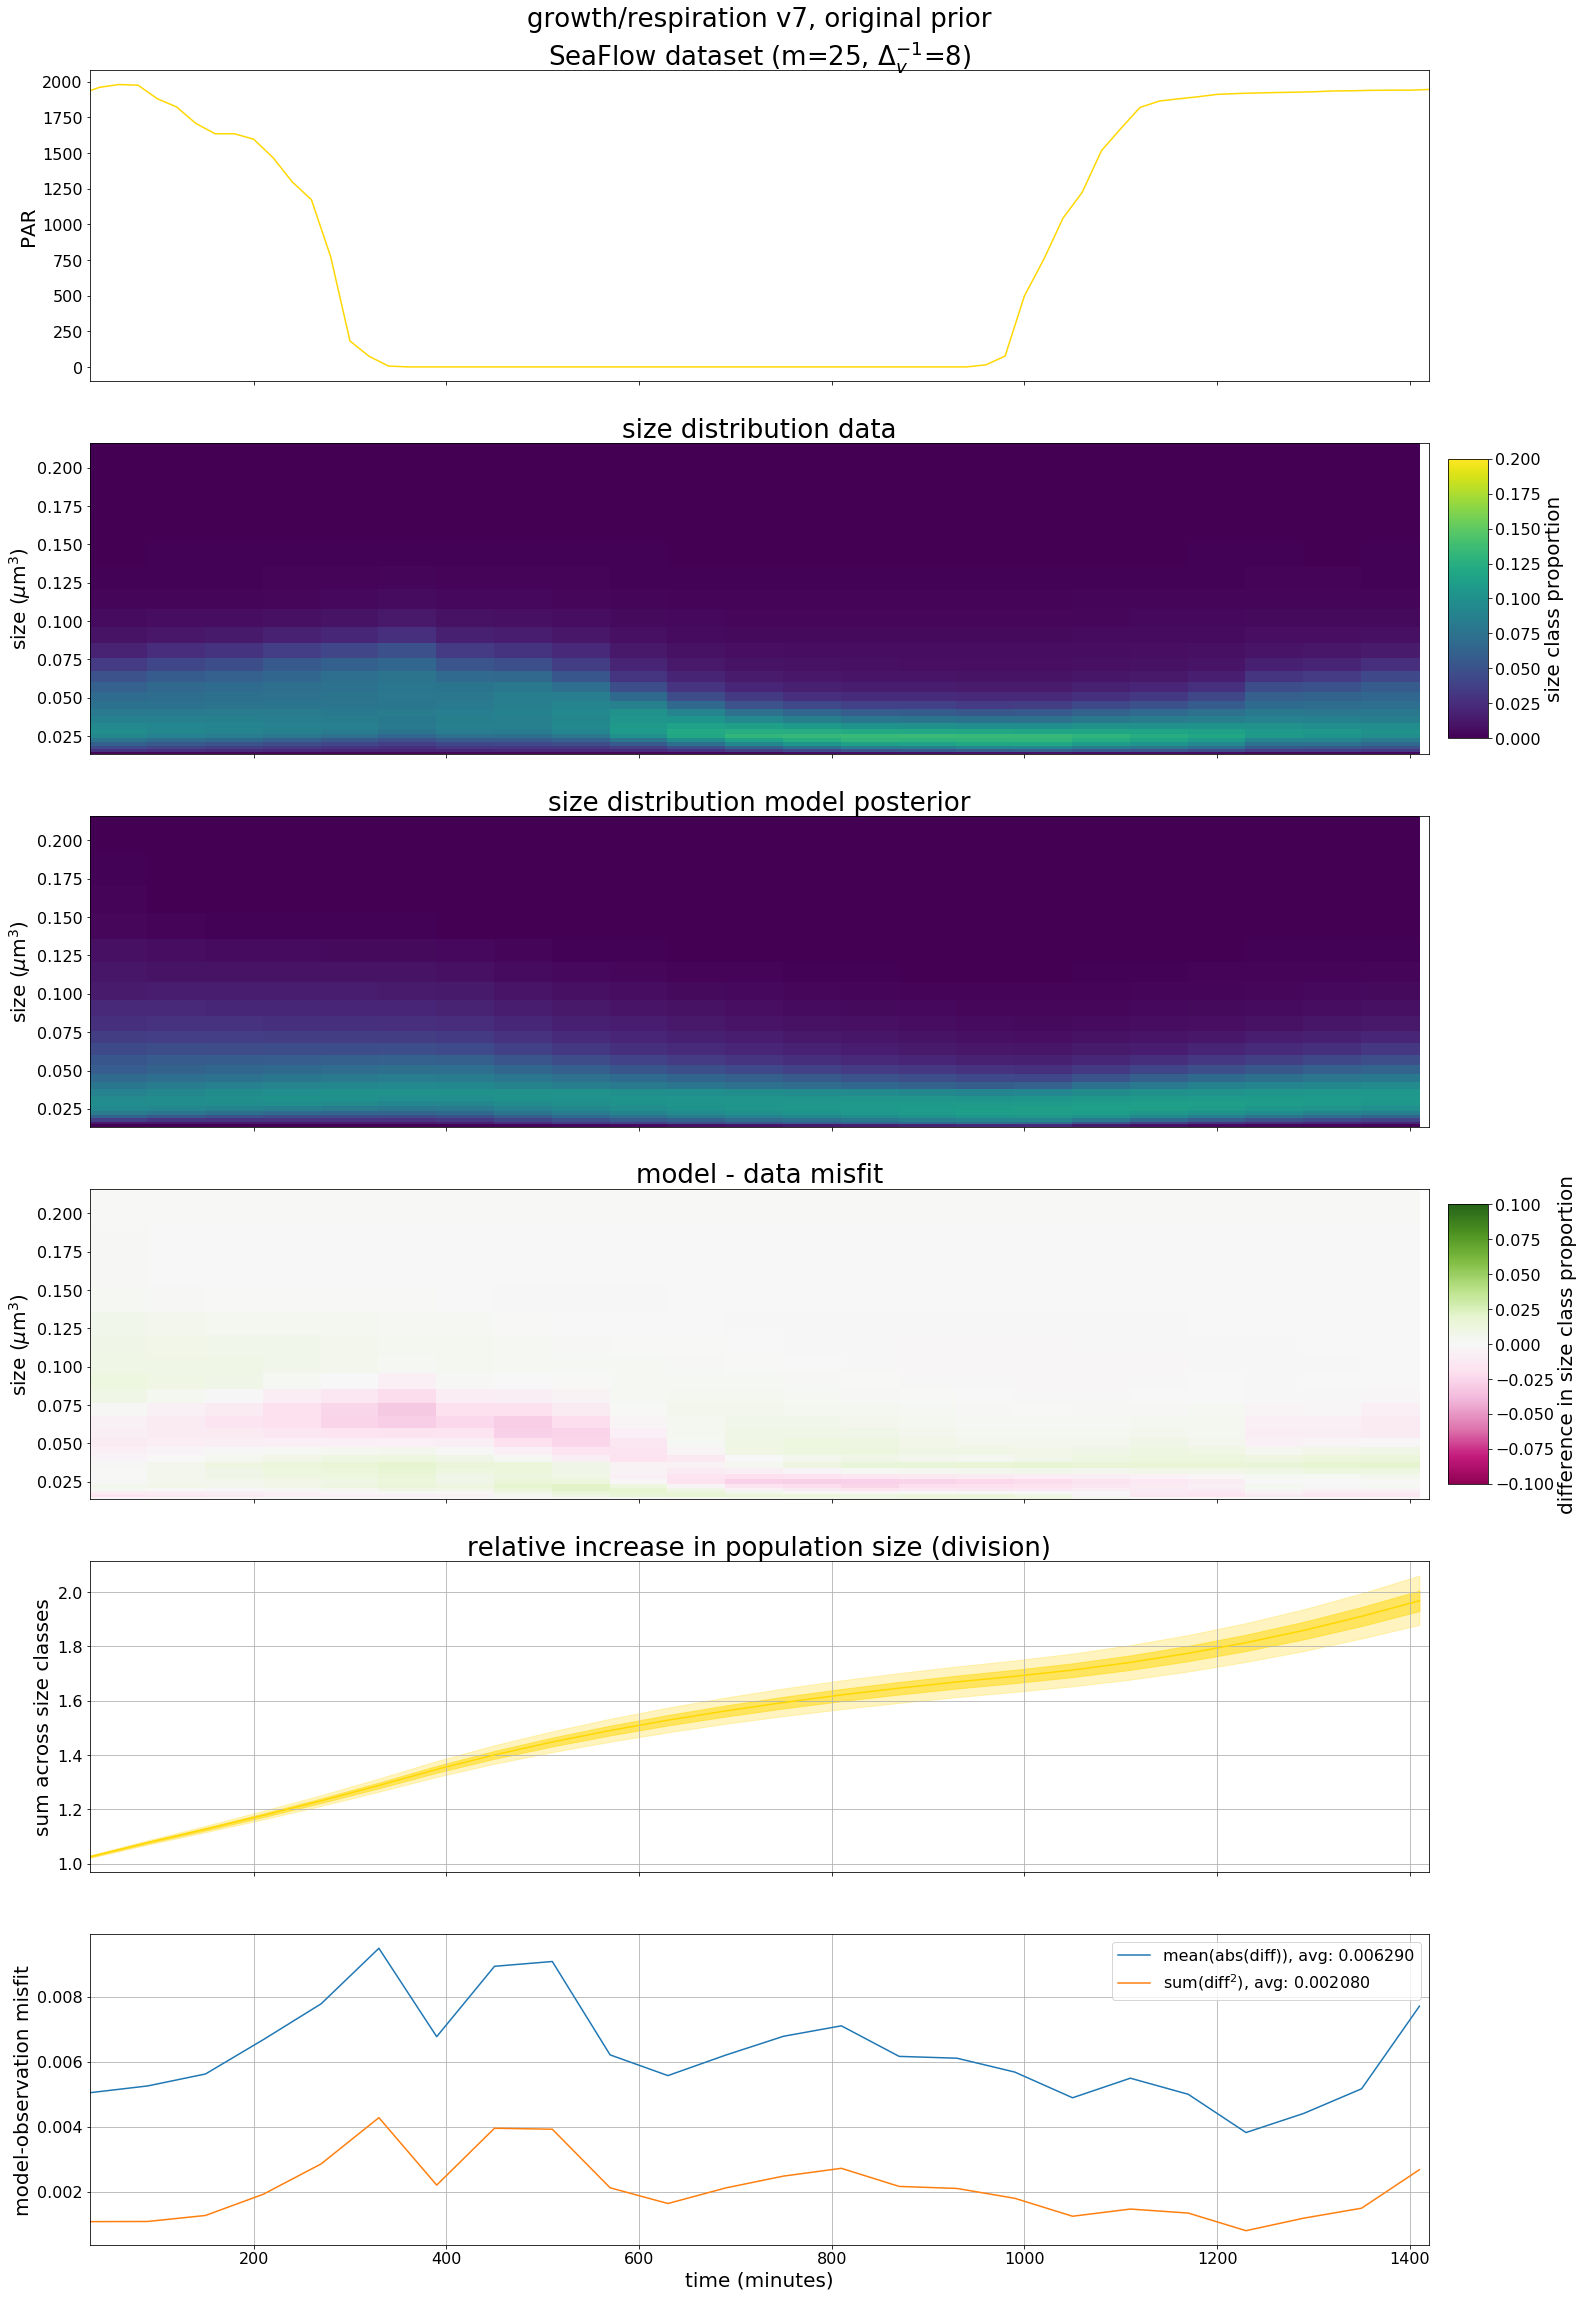

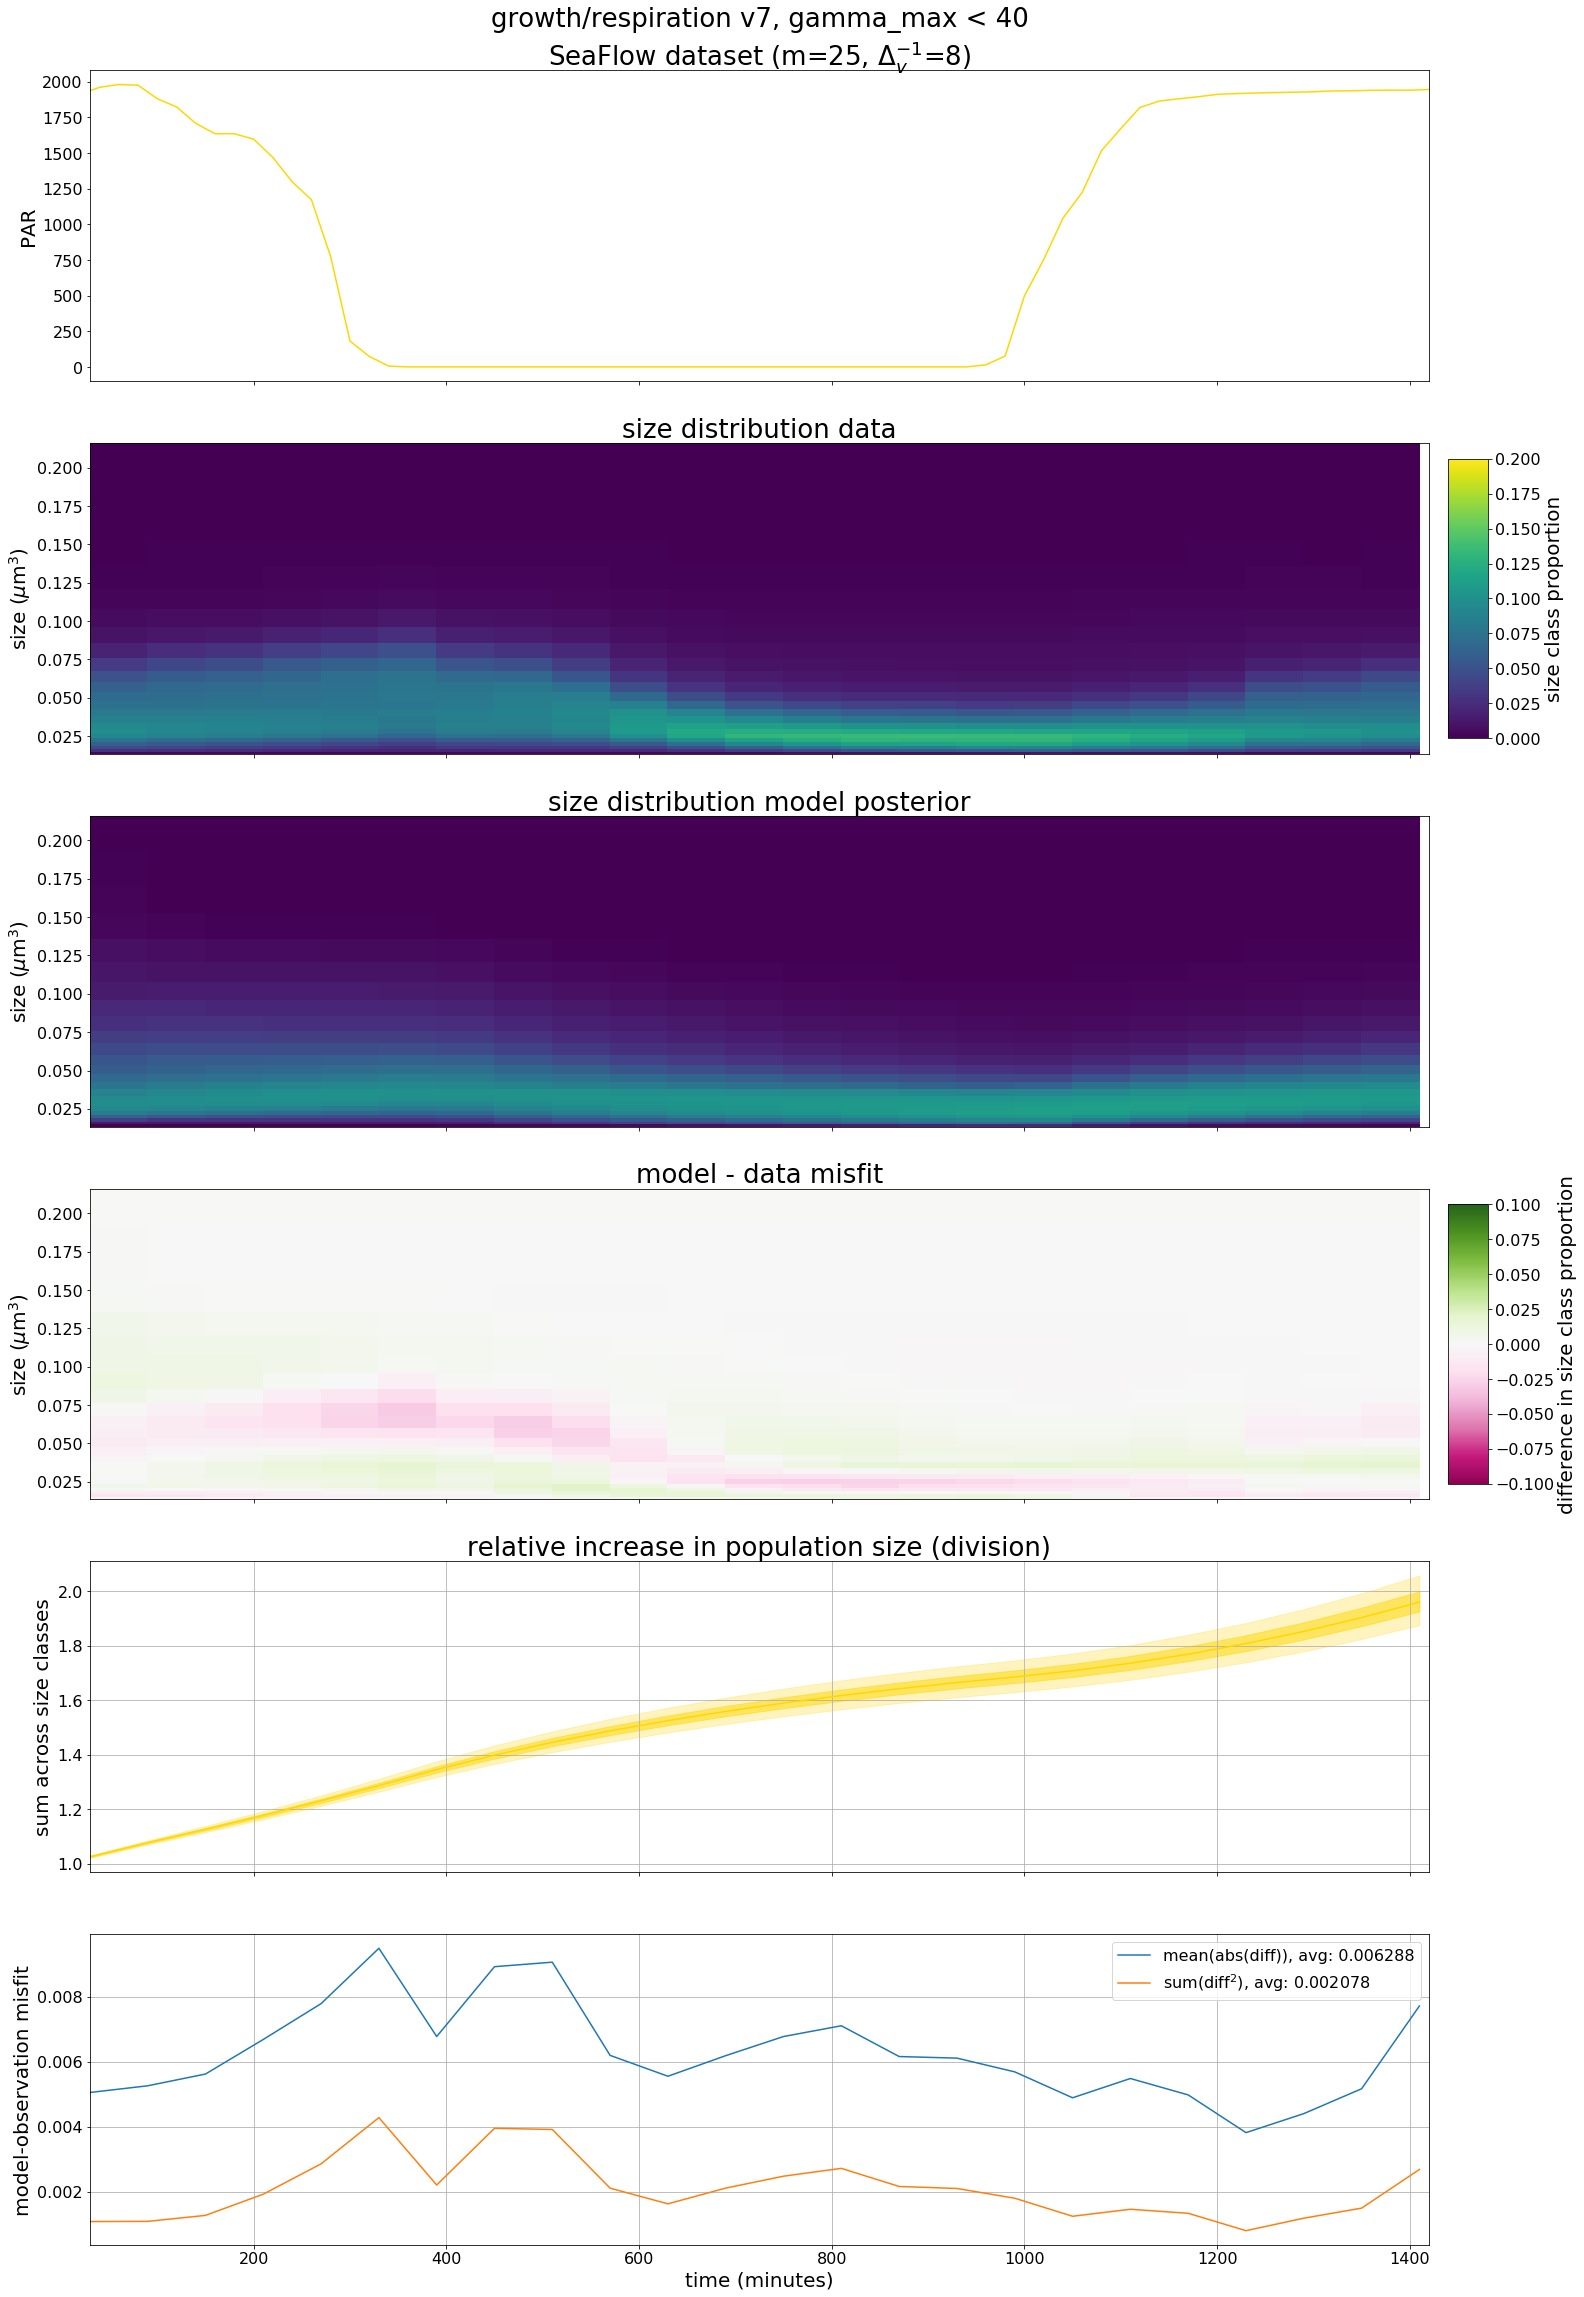

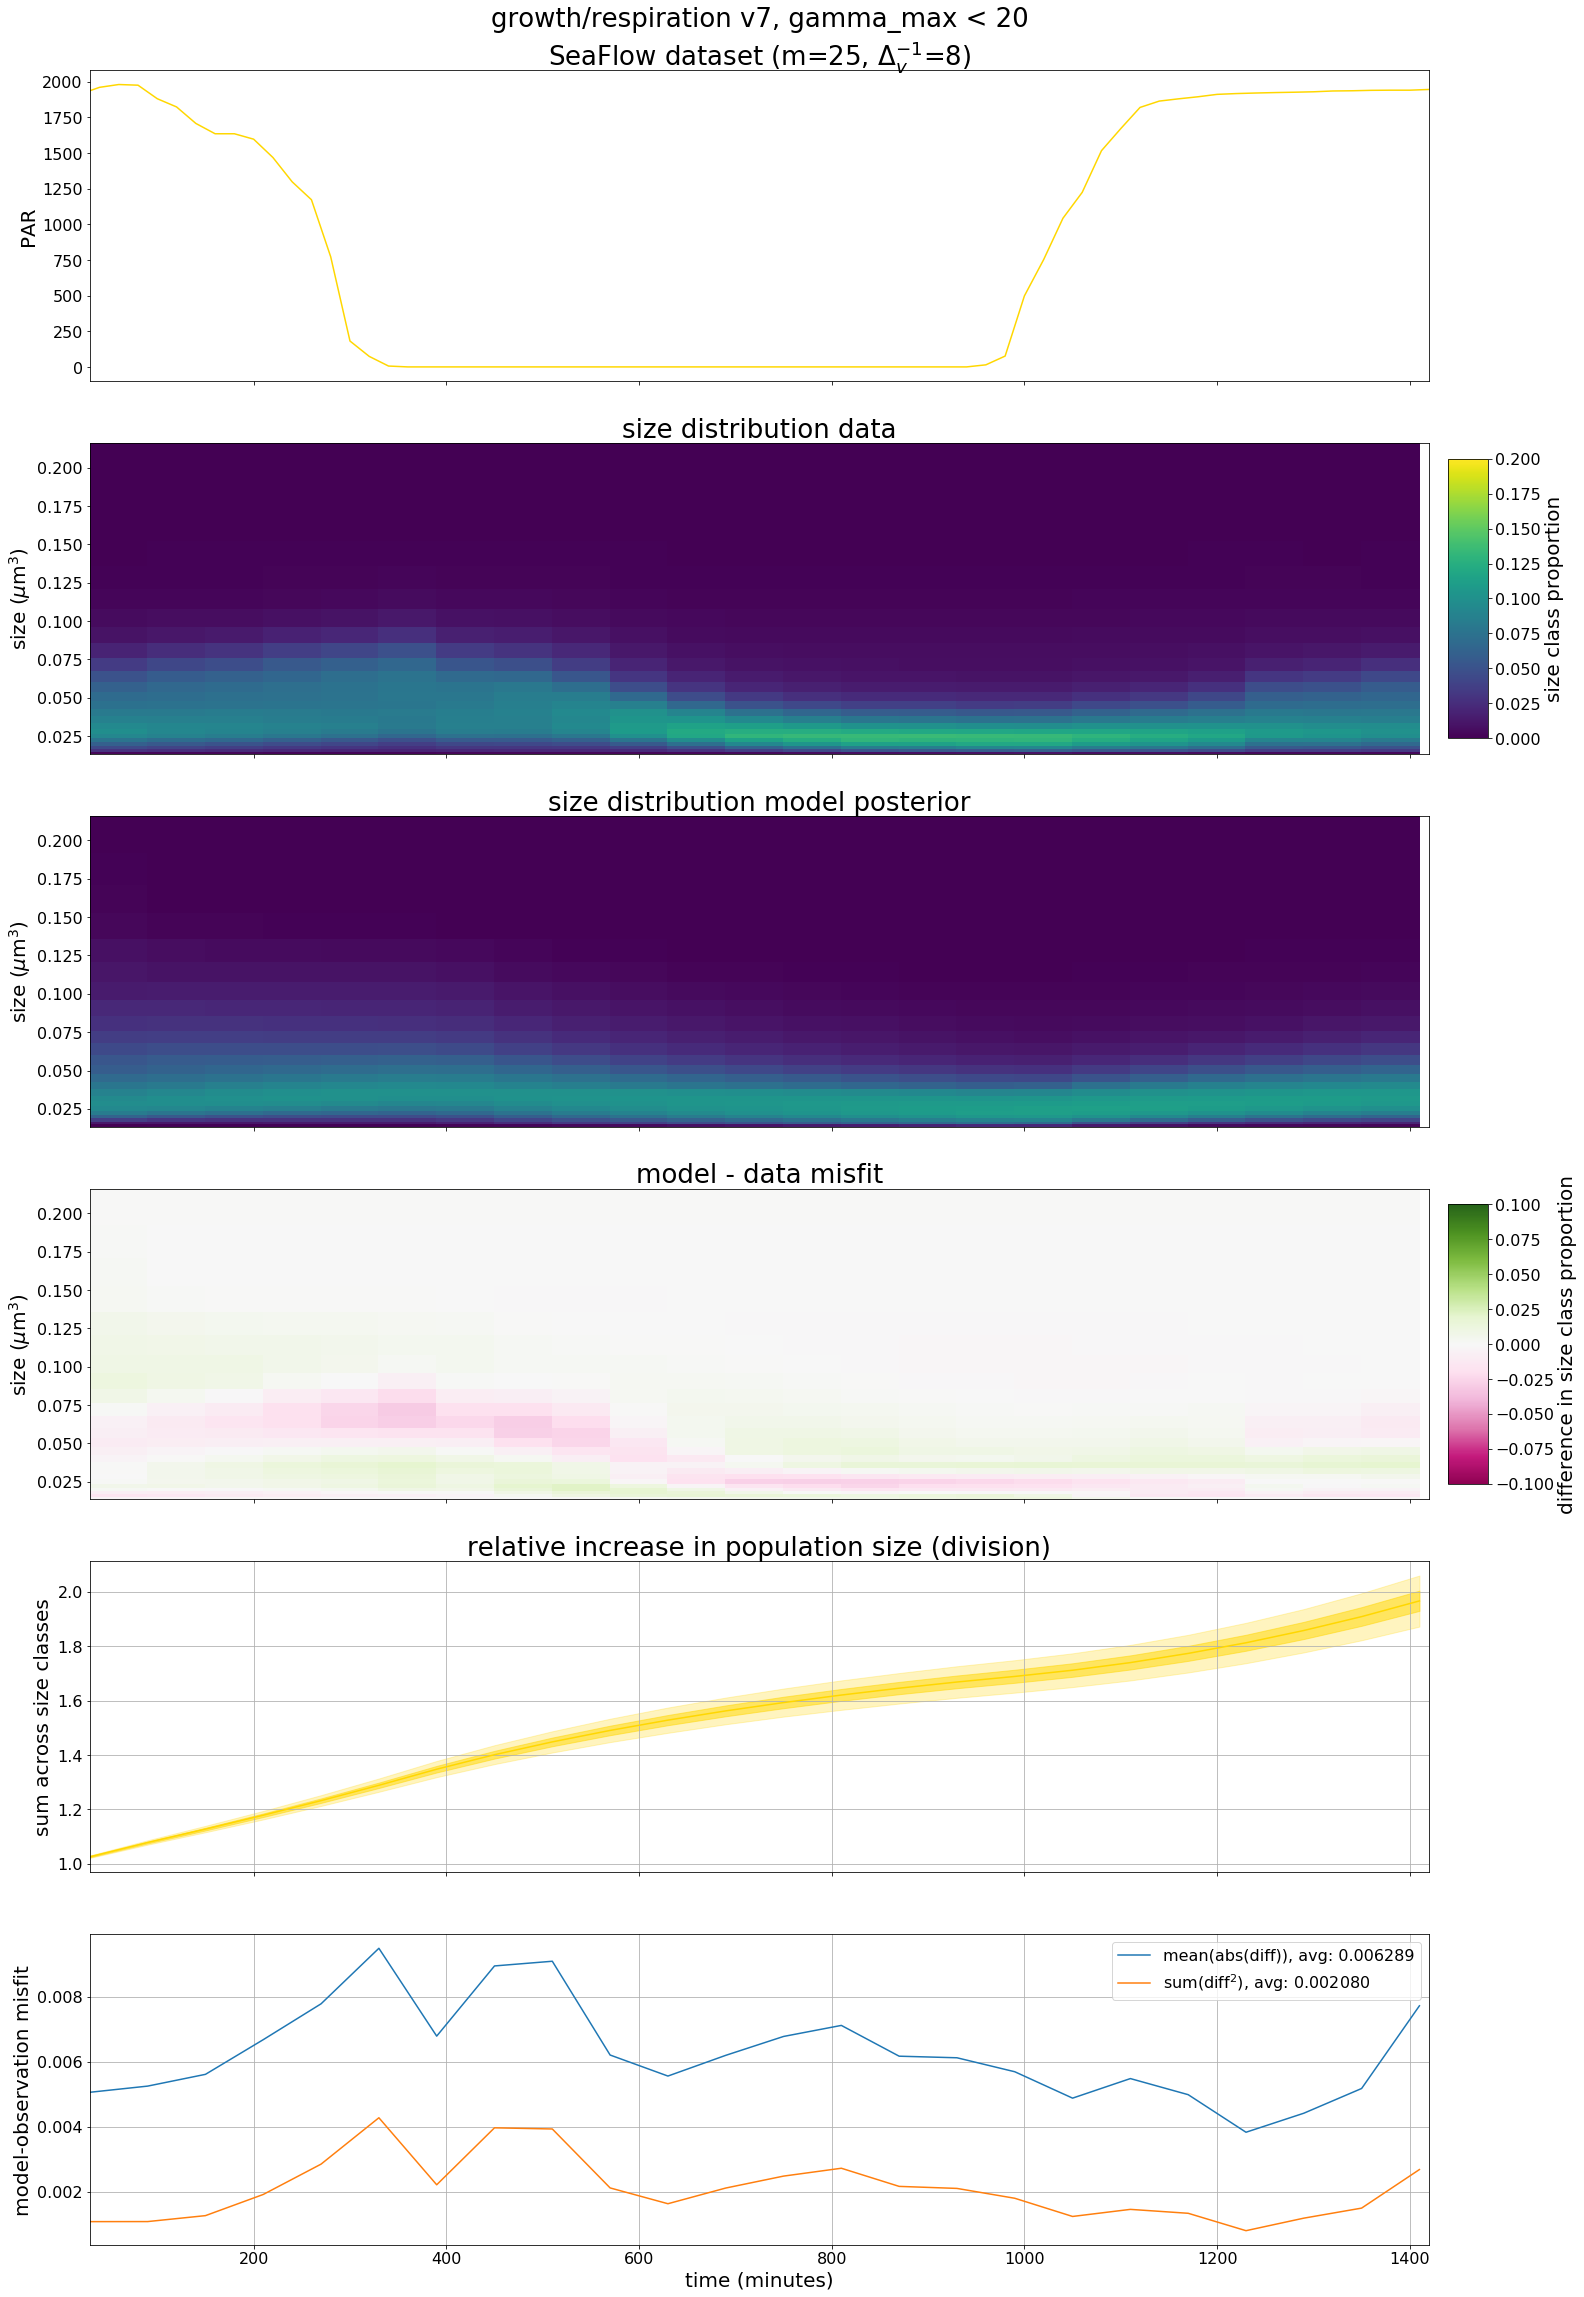

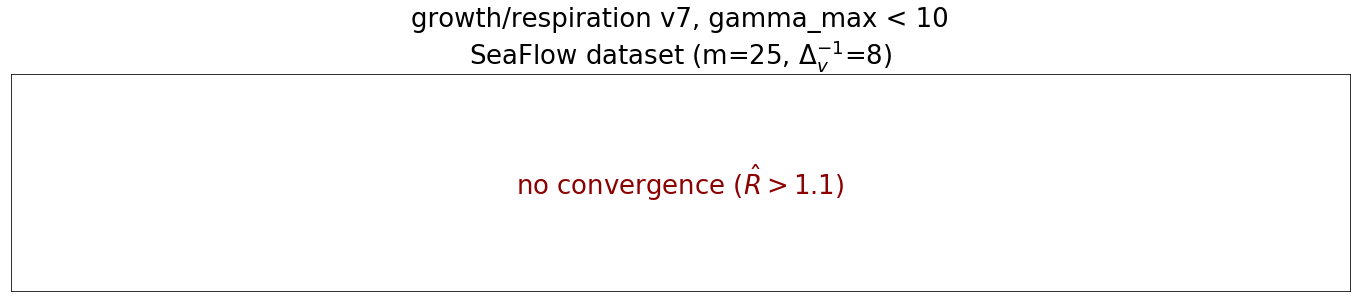

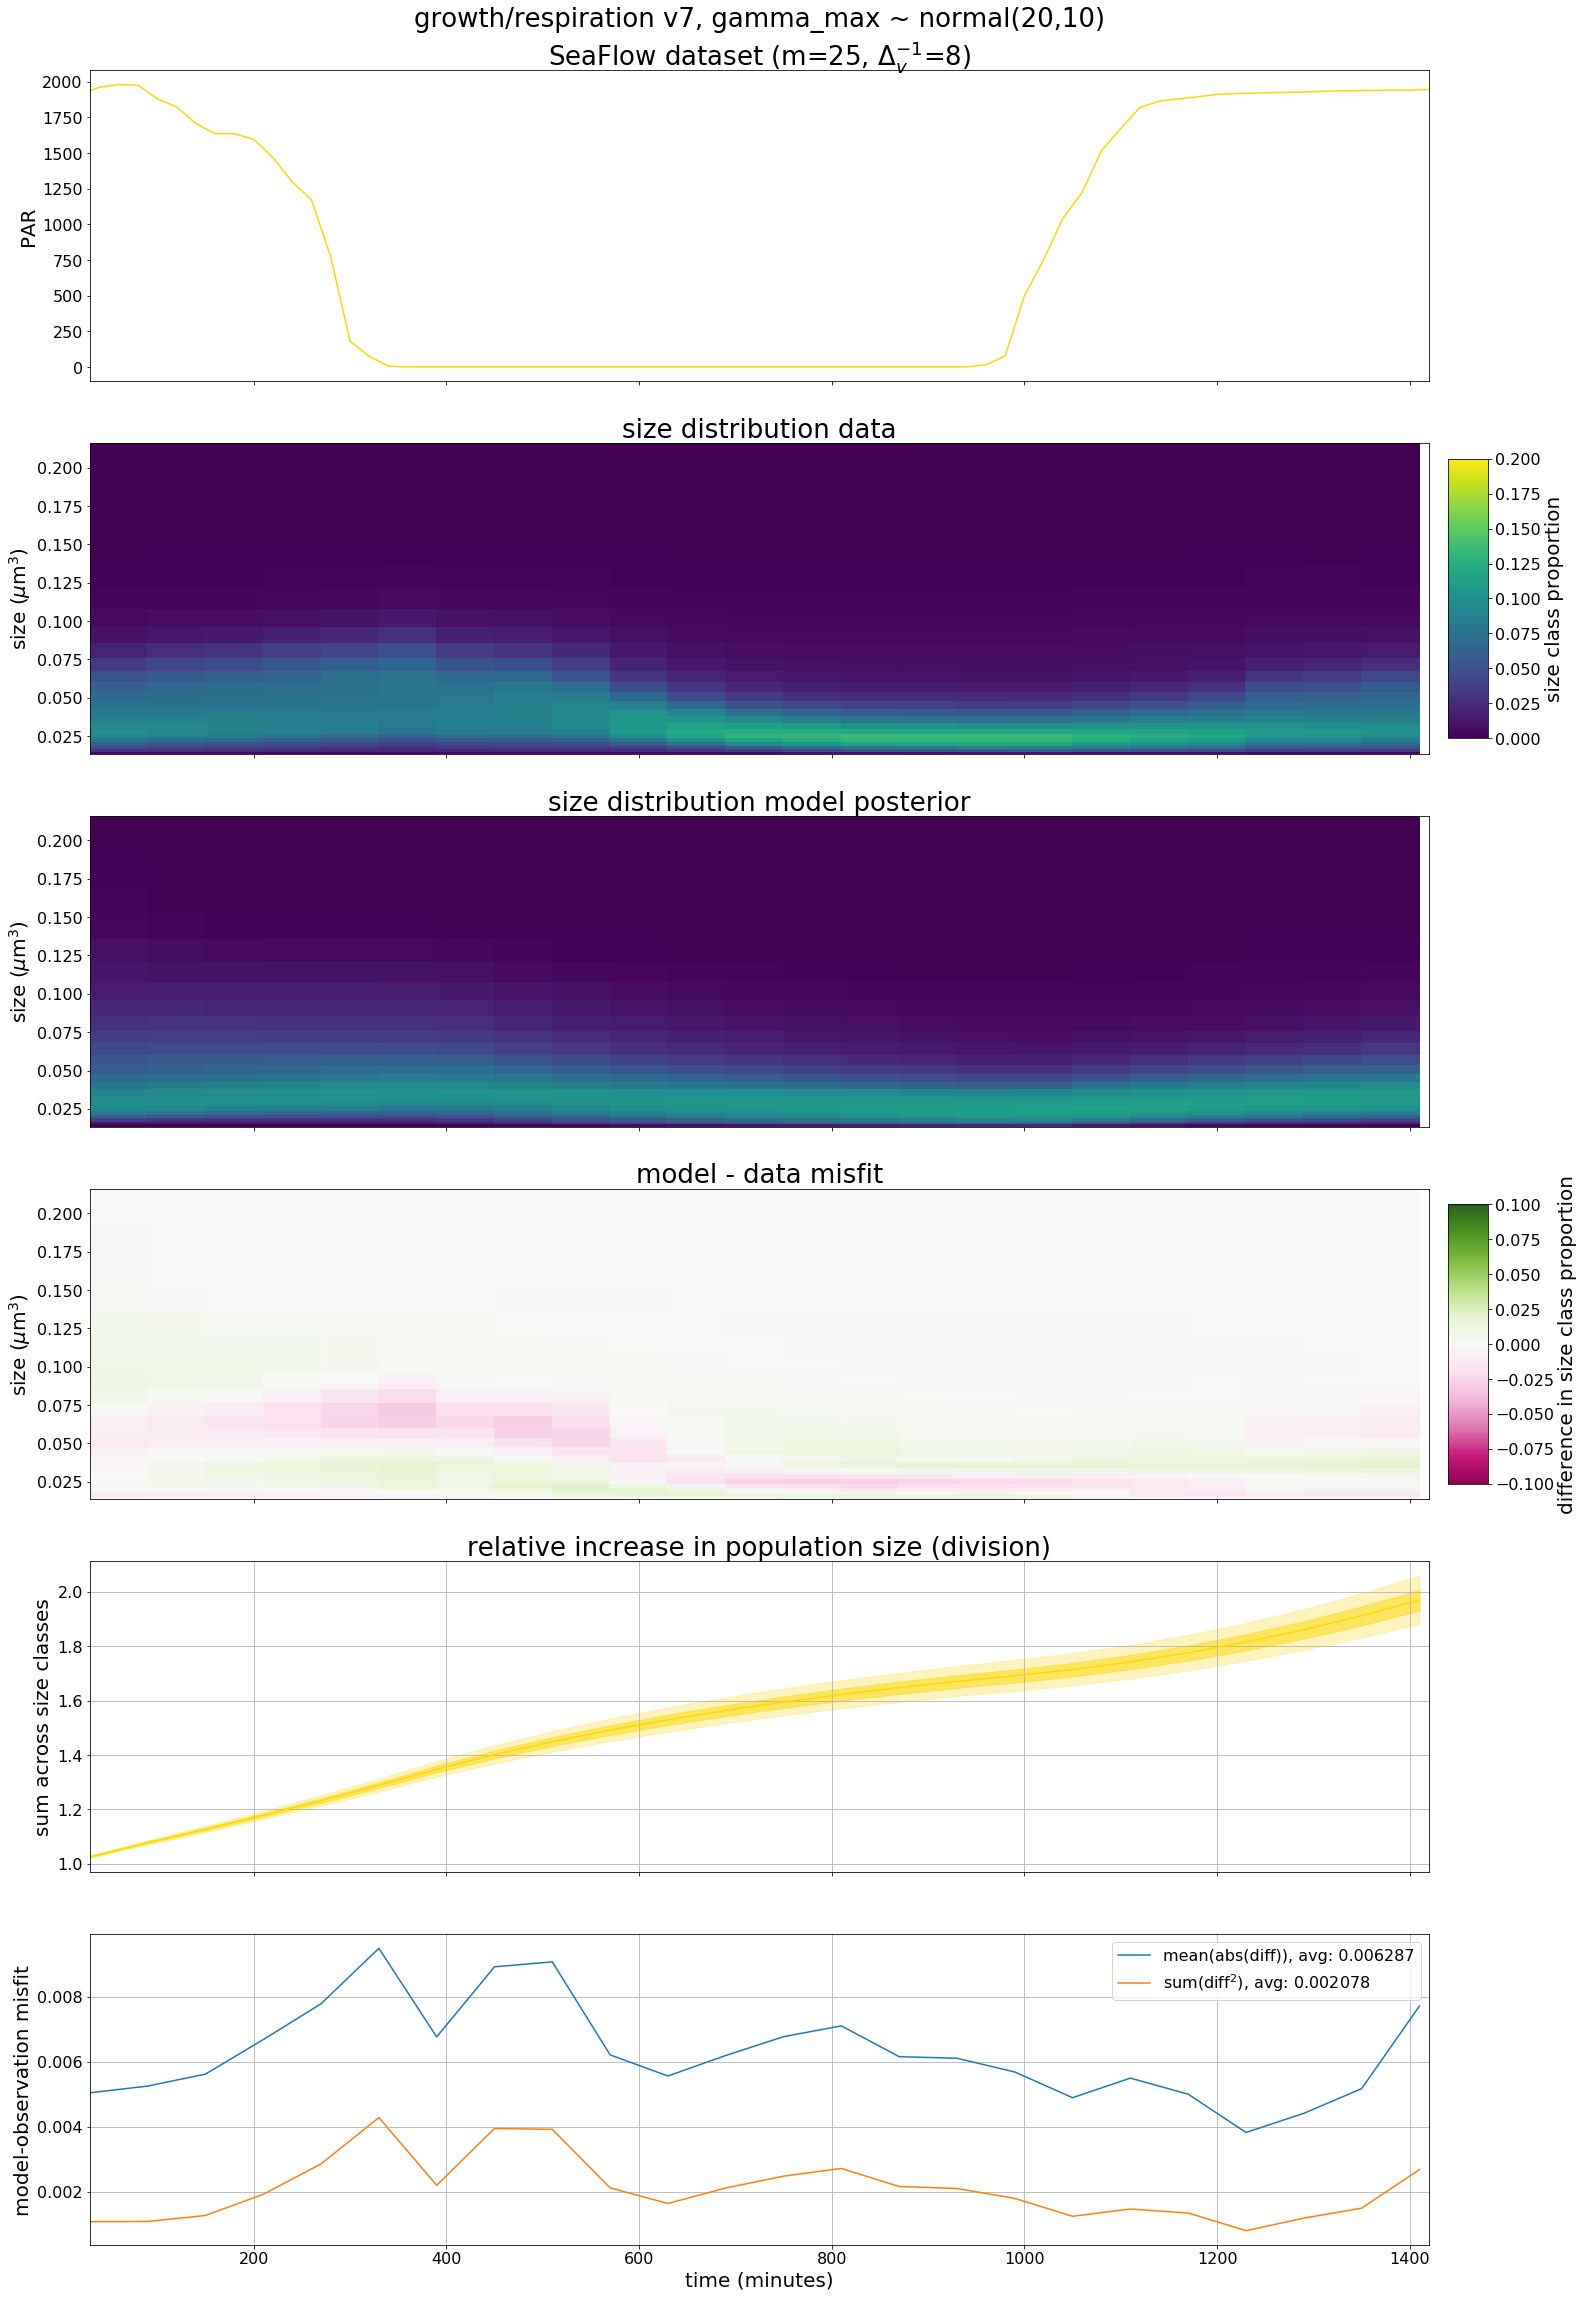

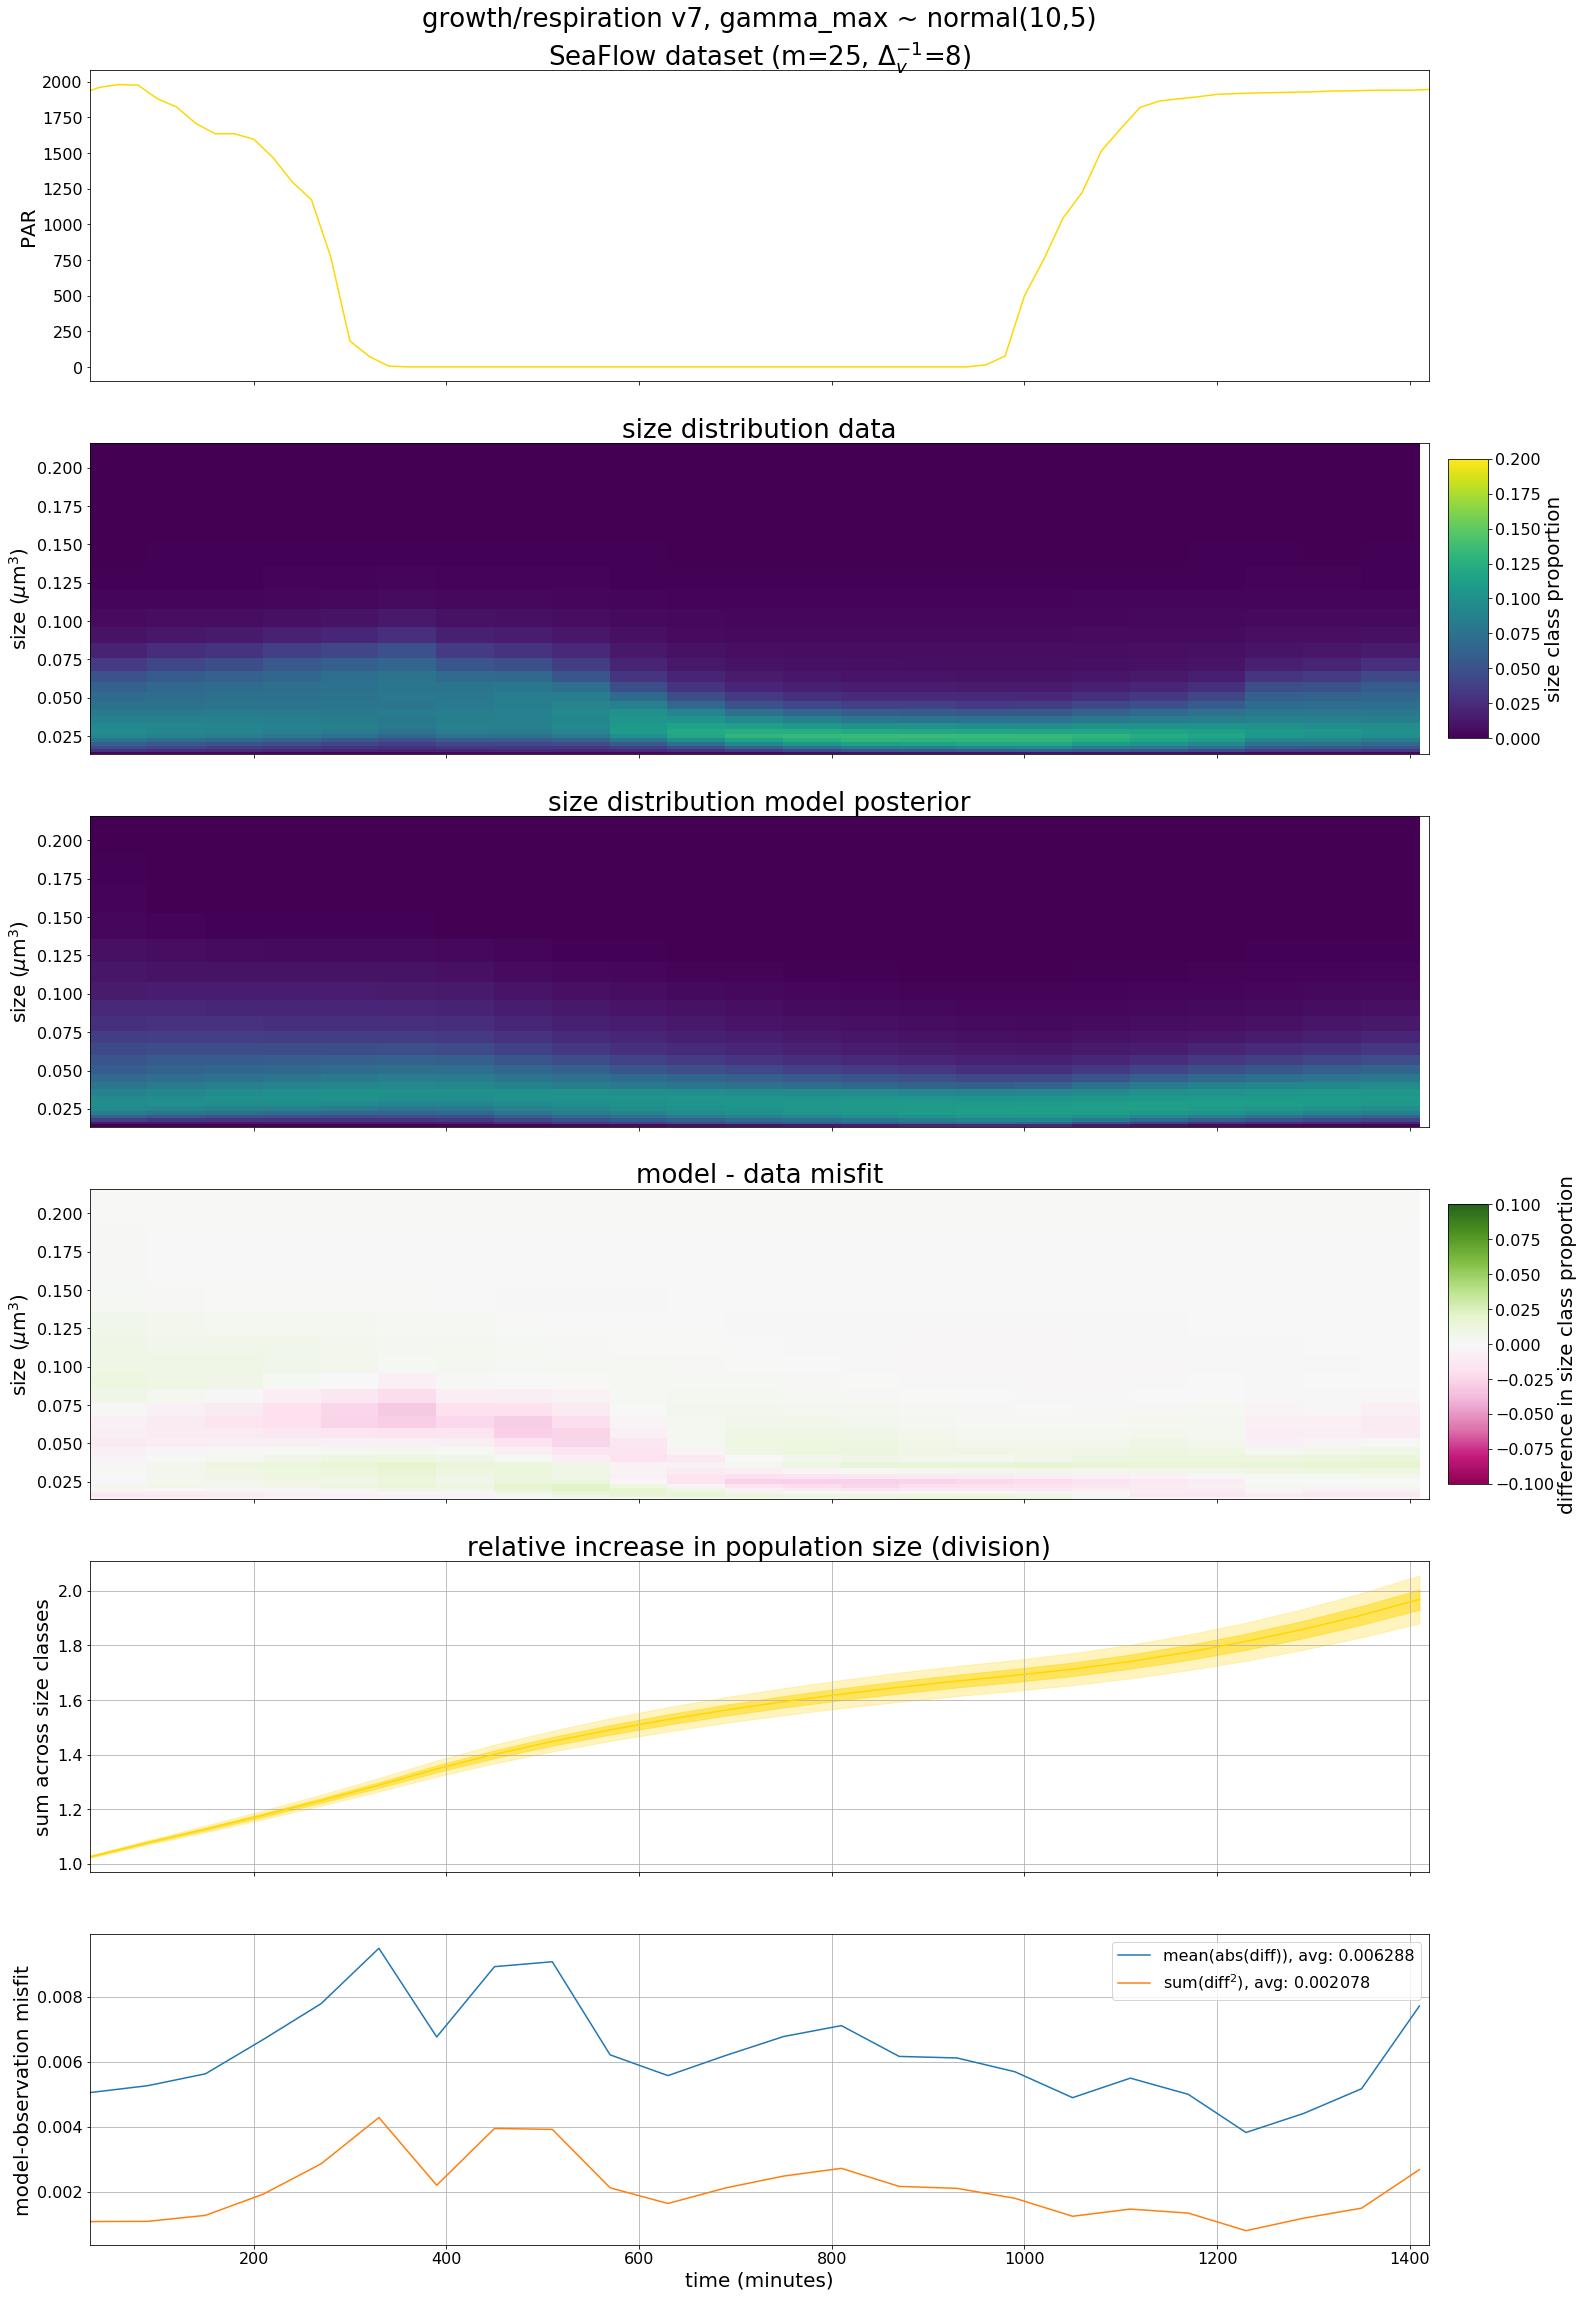

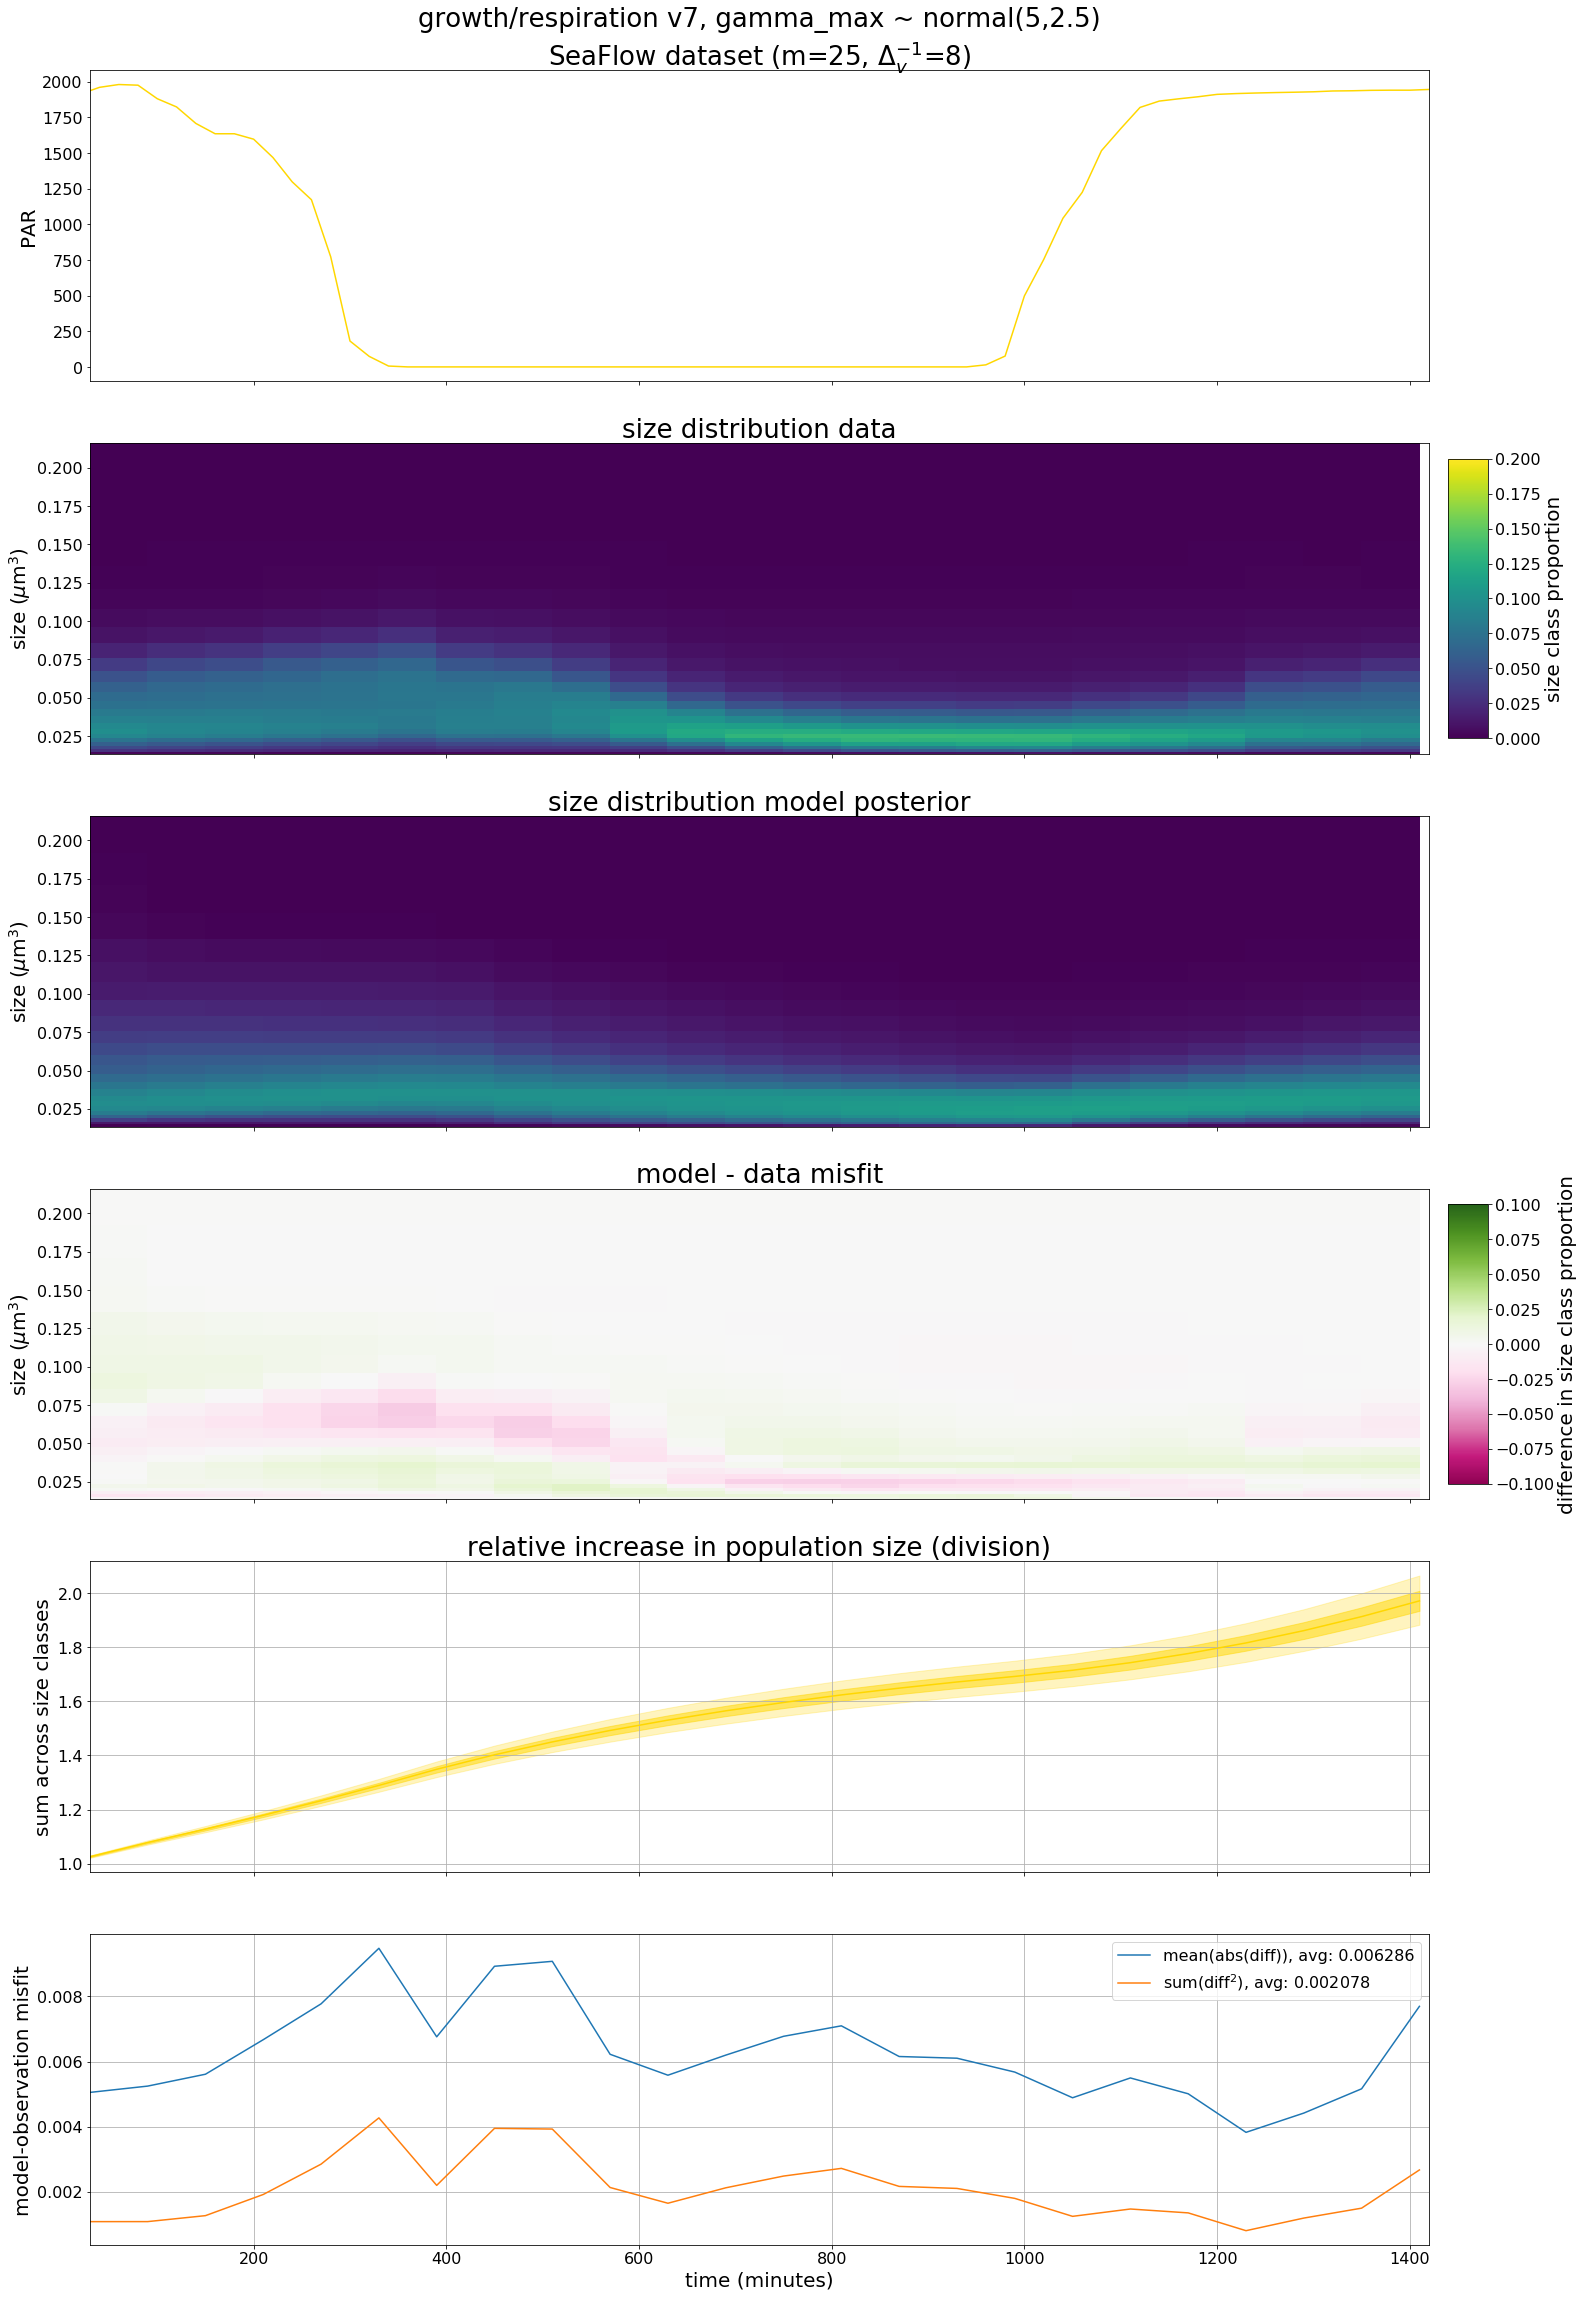

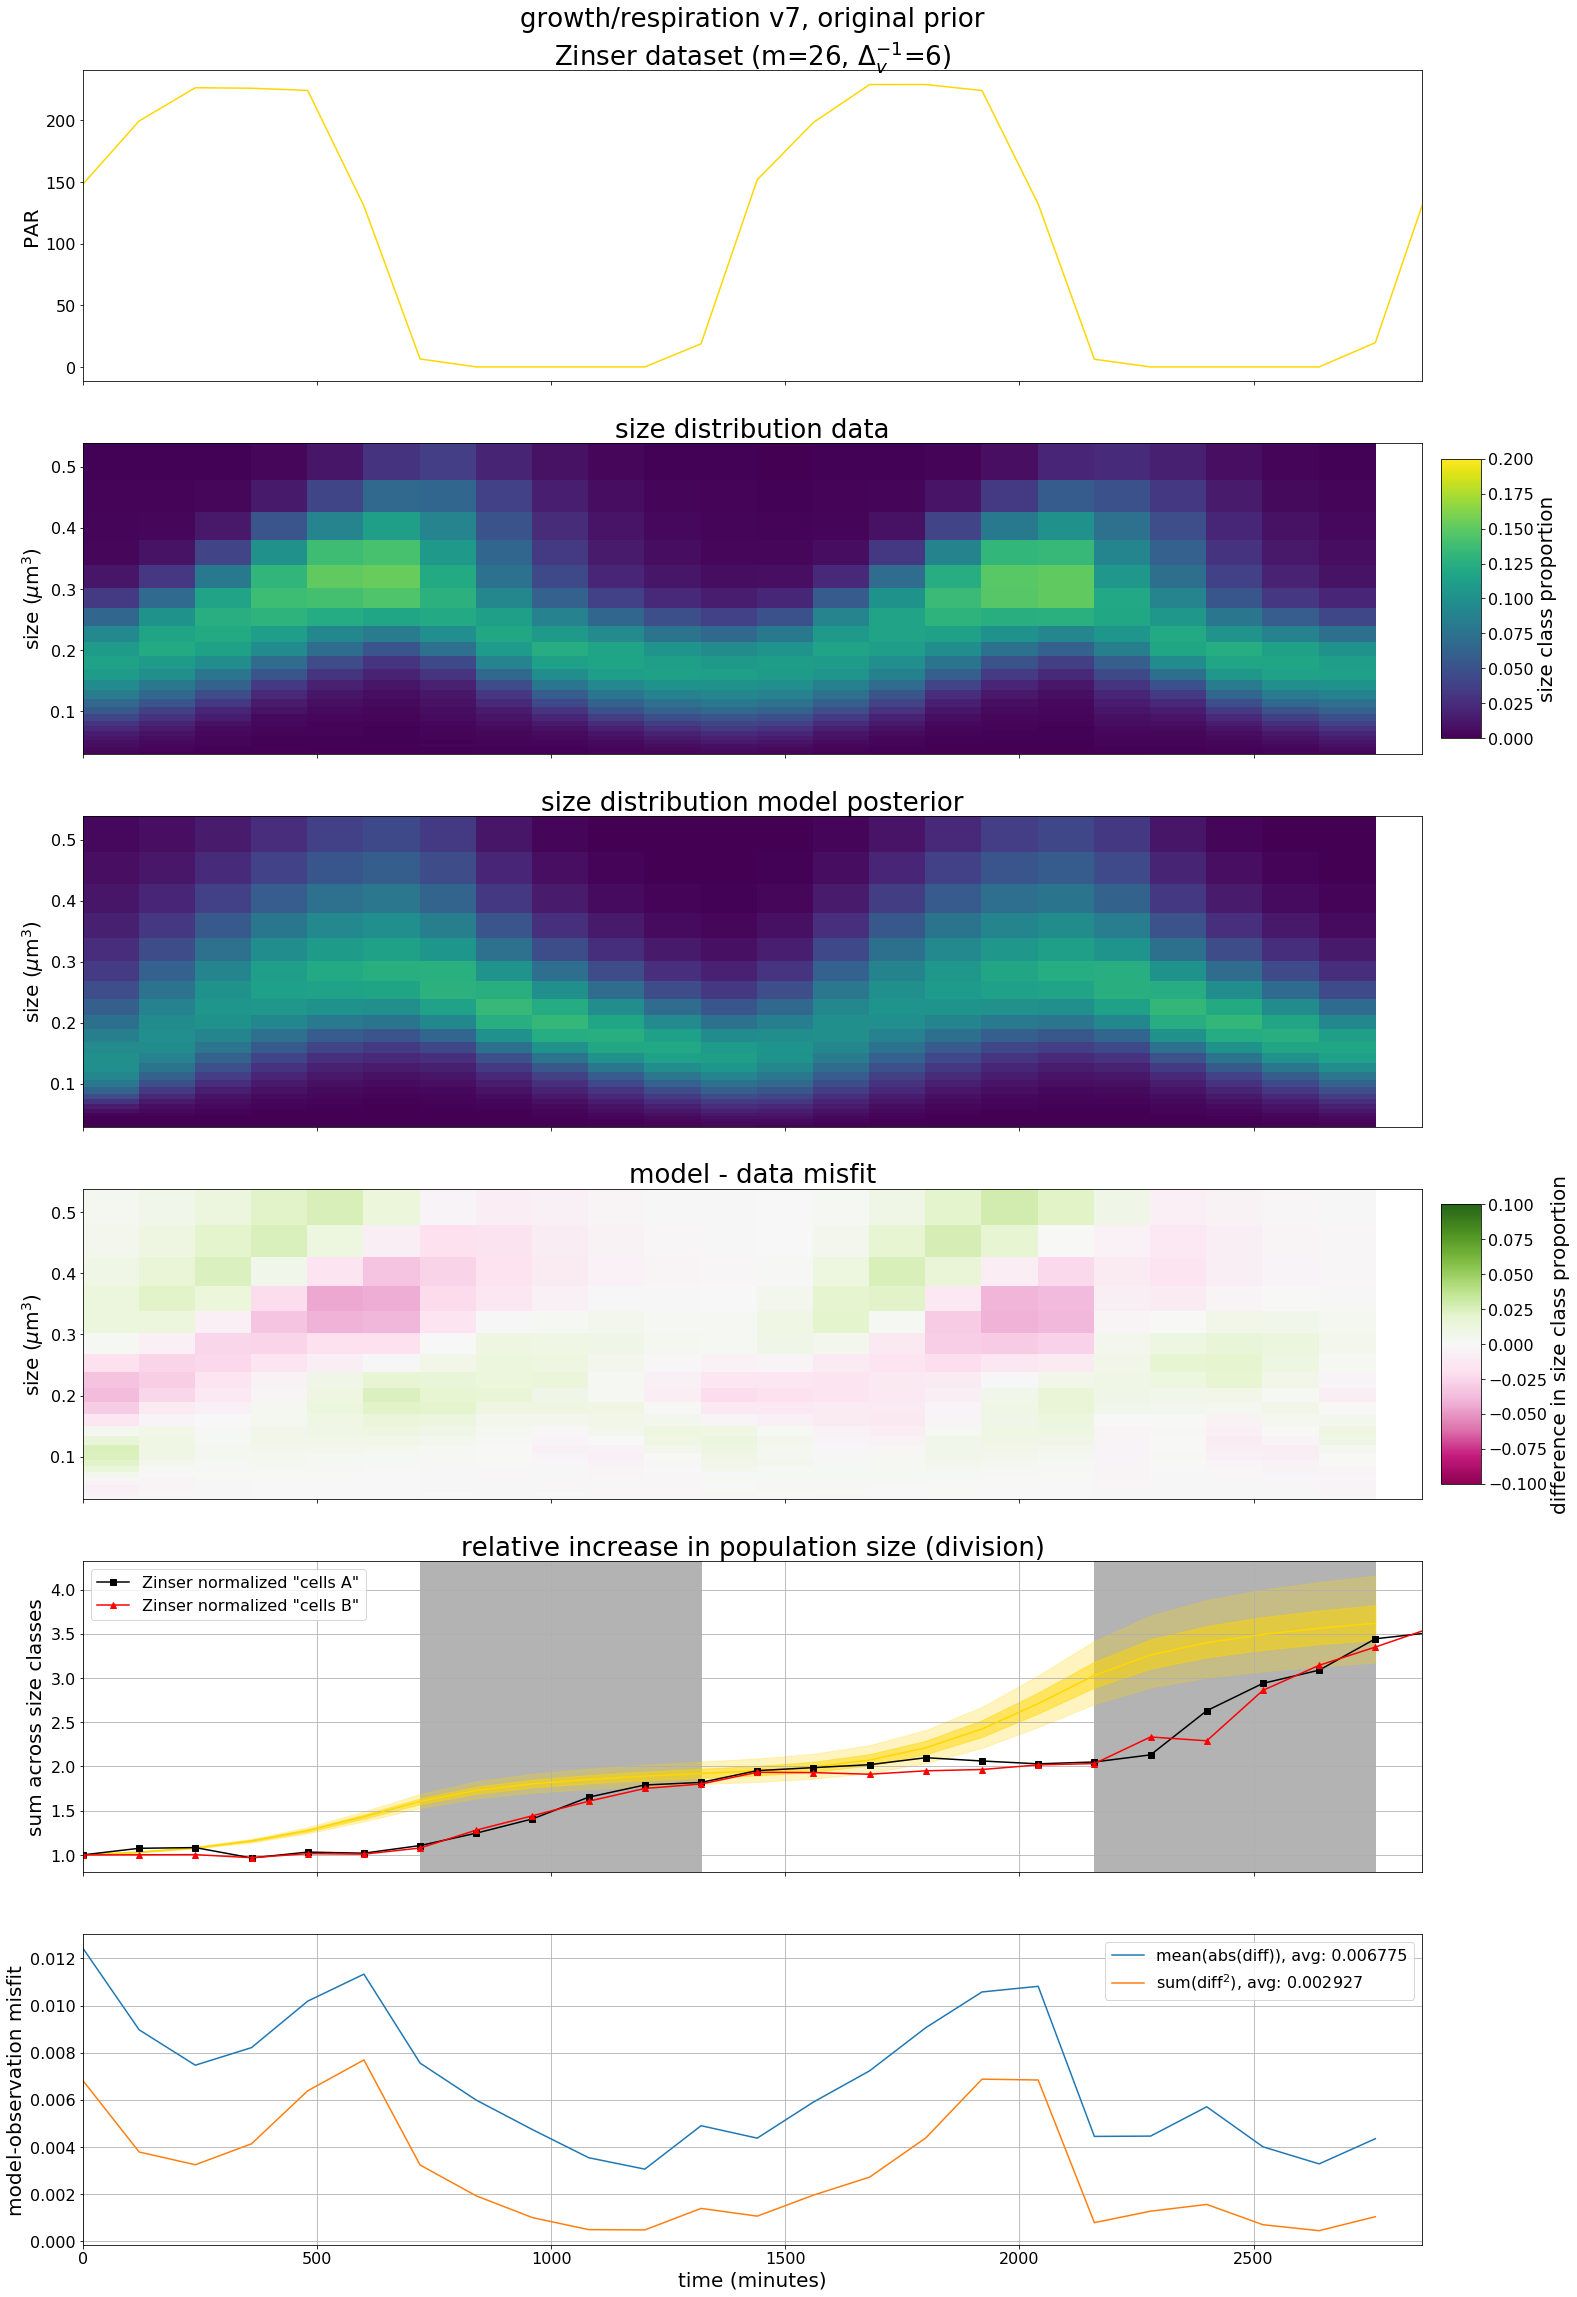

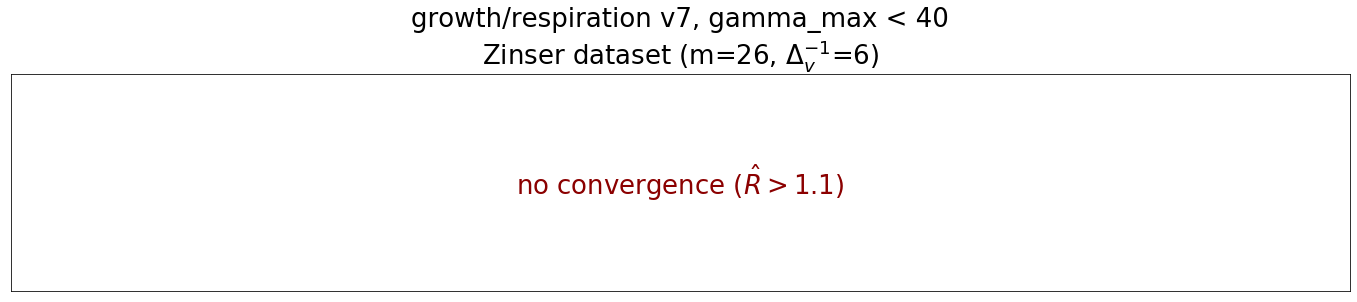

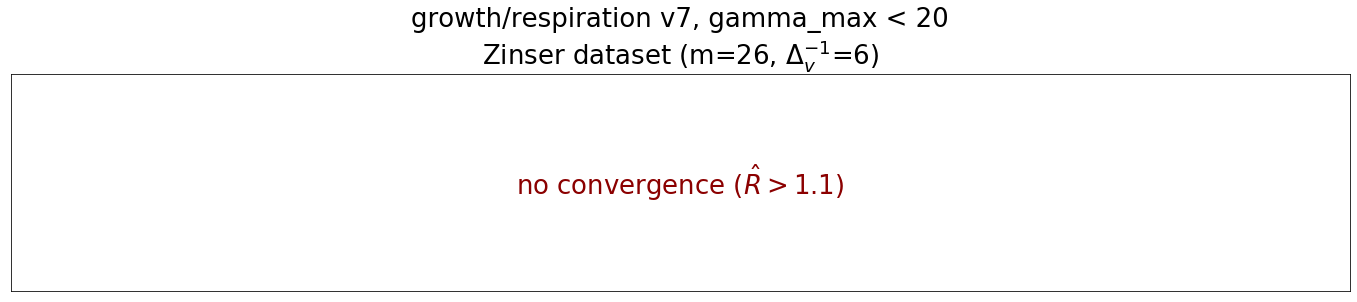

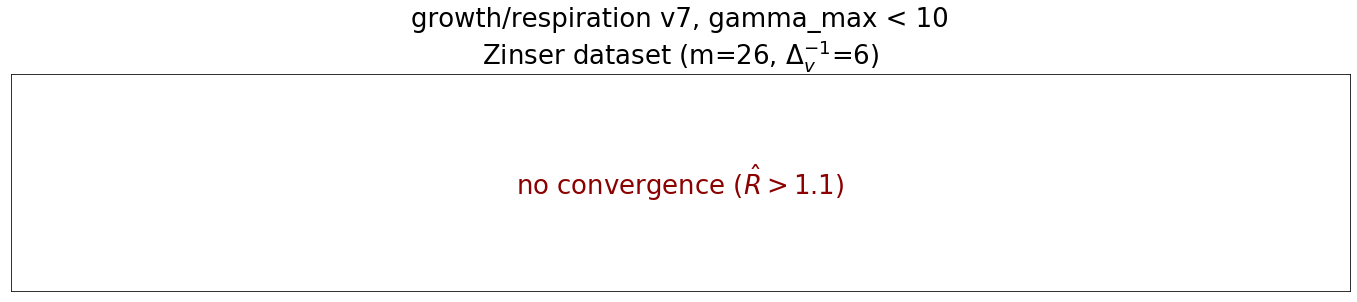

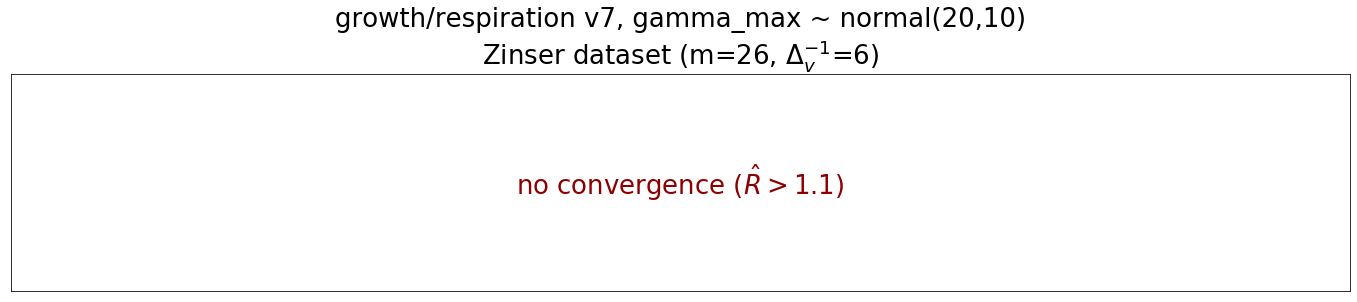

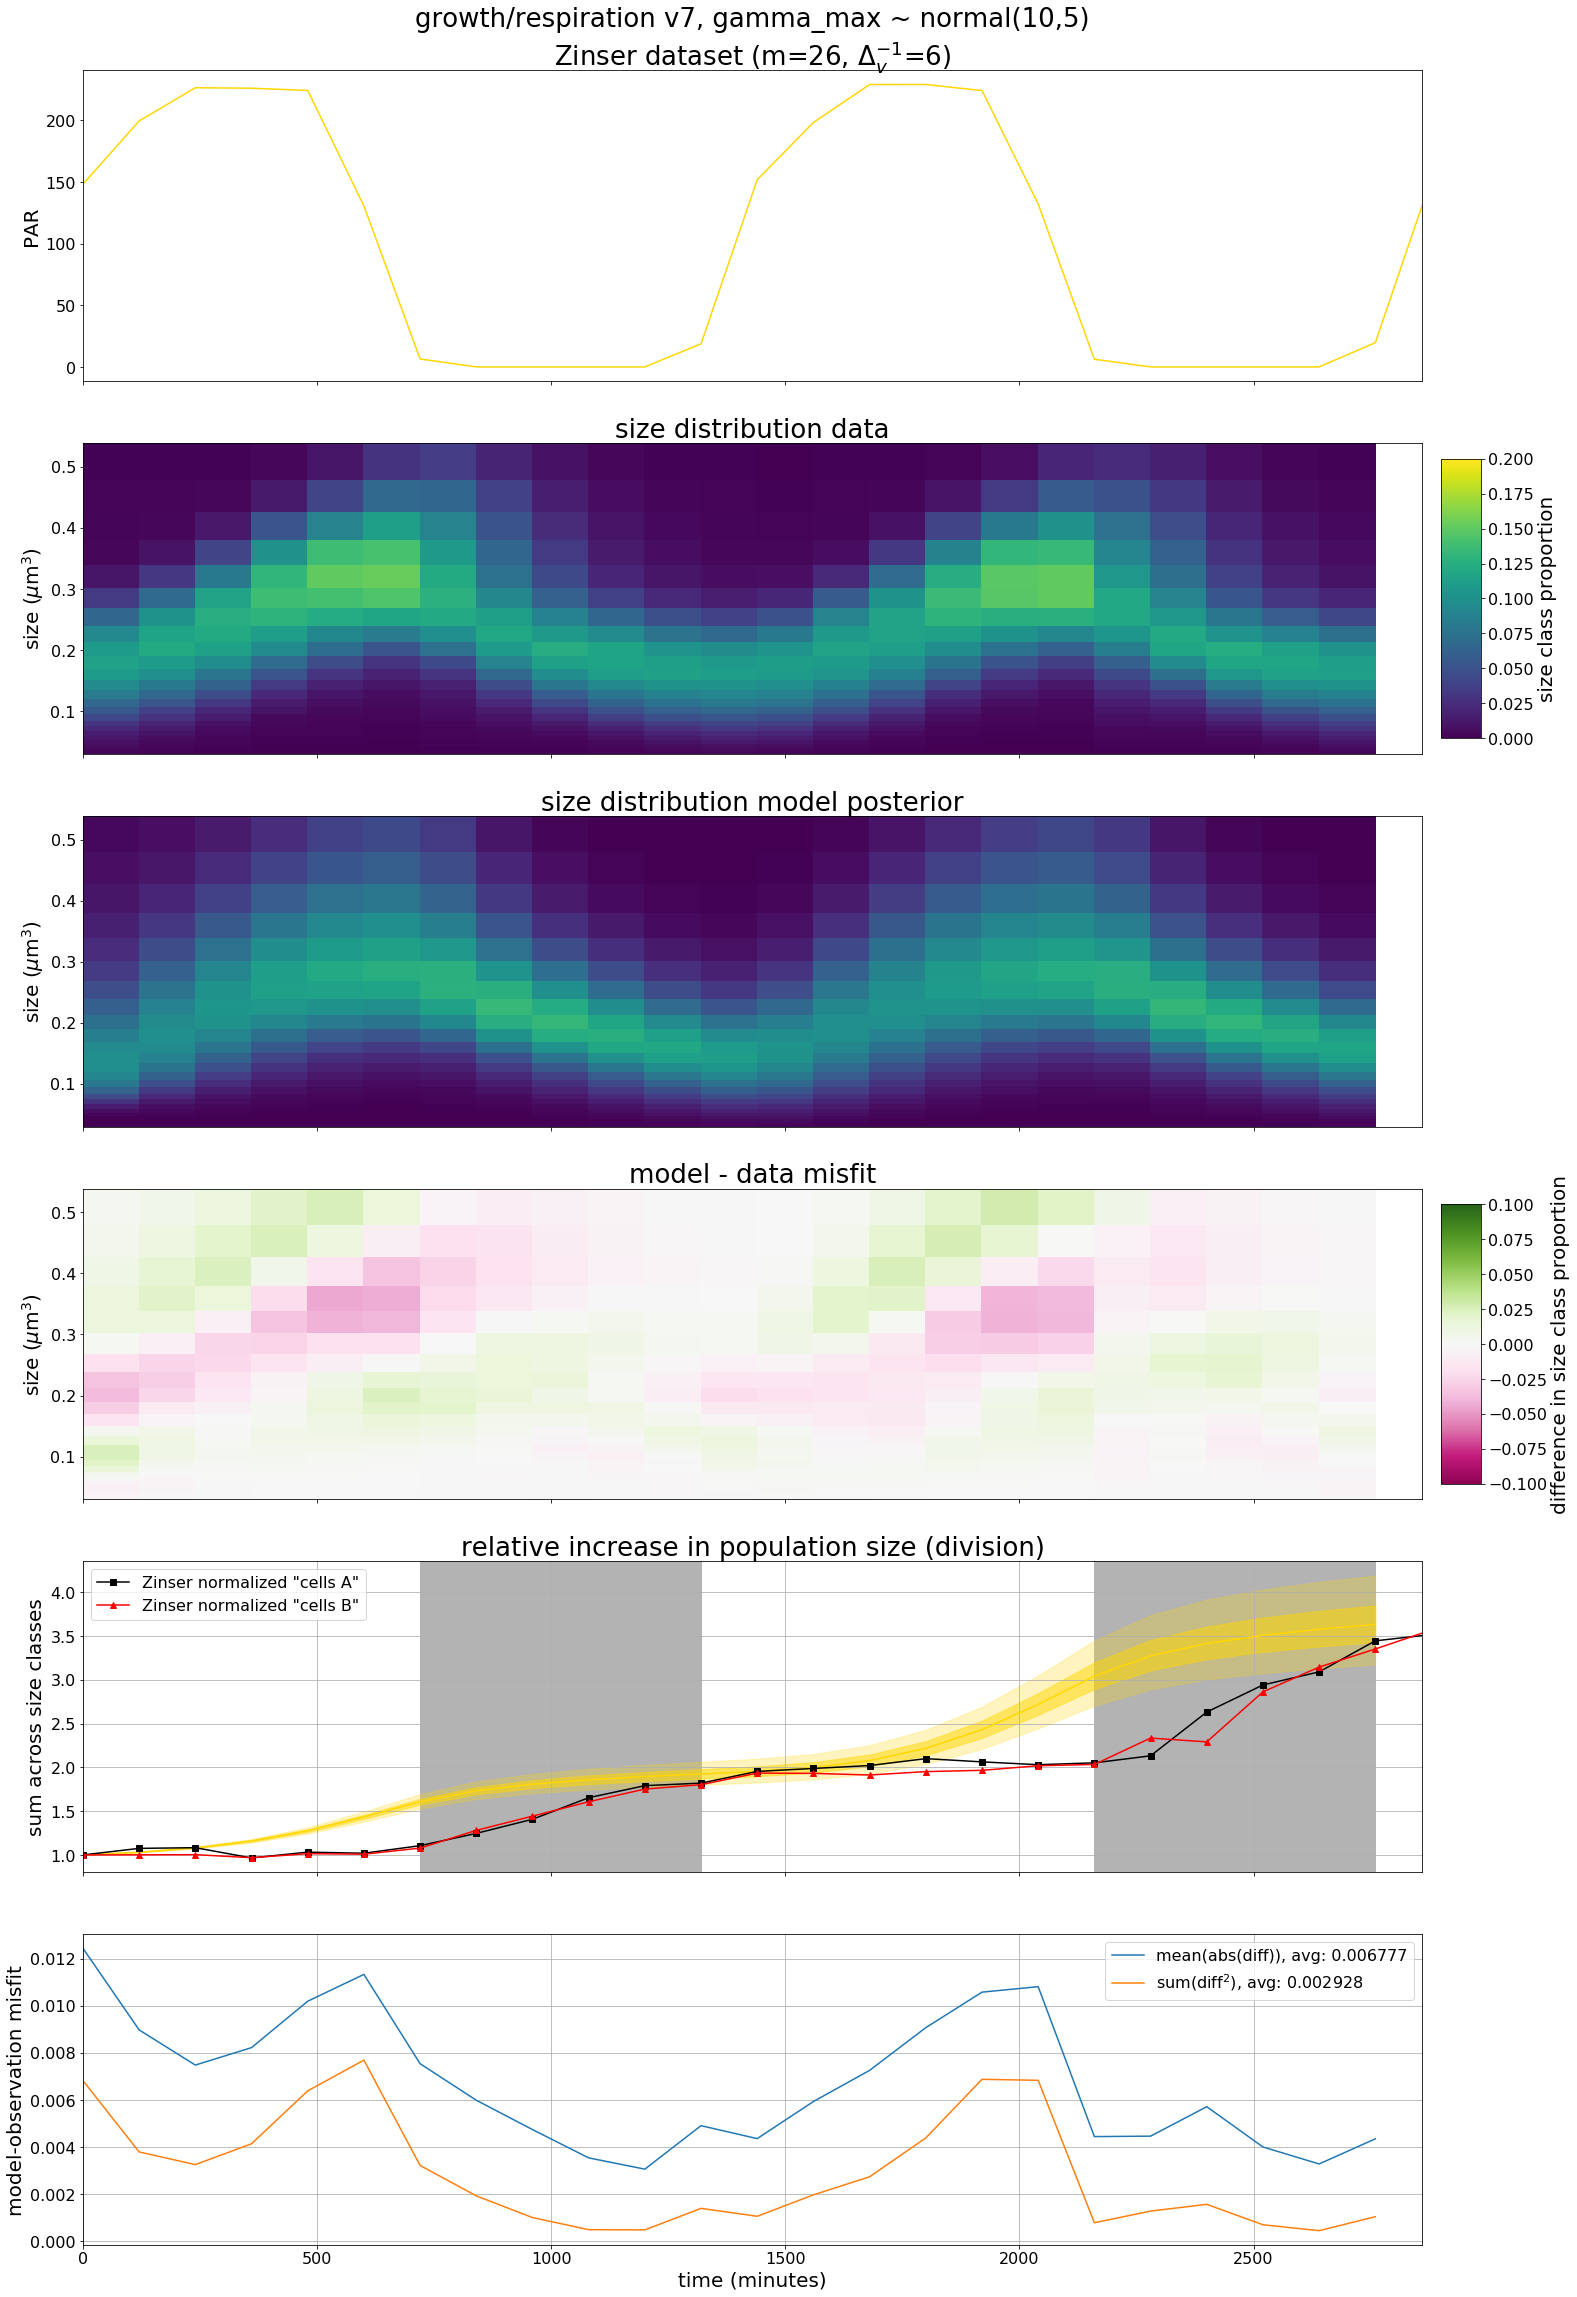

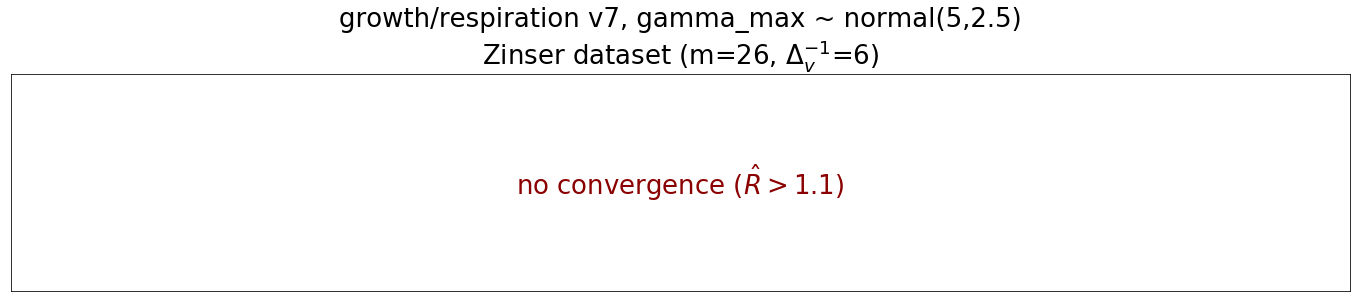

In [14]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()